# Imports and Installations

In [1]:
# !python -m pip install --upgrade pip 
# !python -m pip install xgboost shap openpyxl matplotlib==3.6.2 

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
import pandas as pd
import numpy as np

weather_df = (pd.read_excel("los angeles county 2000-01-04 to 2022-09-18.xlsx", 
                  parse_dates = ["datetime"], 
                  index_col = "datetime"
               ).resample("W-TUE").median()).iloc[:-1]

drought_df = pd.read_excel("Percent Area in US Drought Monitor Categories.xlsx", 
                  parse_dates =["Week"], 
                  index_col = "Week")

# Exploratory Data Analysis

## Initial visual inspection using df.head()

In [4]:
weather_df.head()

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2000-01-04     67.4     46.2  55.6          67.4          46.2       55.4   
2000-01-11     63.7     45.0  54.9          63.7          45.0       54.9   
2000-01-18     74.0     58.2  62.2          74.0          58.2       62.2   
2000-01-25     63.4     55.7  58.5          63.4          55.7       58.5   
2000-02-01     65.5     49.2  55.7          65.5          49.2       55.6   

             dew  humidity  precip  precipprob  ...  windspeed  winddir  \
datetime                                        ...                       
2000-01-04  34.9     48.58     0.0         NaN  ...        9.2    195.2   
2000-01-11  36.7     58.03     0.0         NaN  ...        7.3    178.8   
2000-01-18  51.7     70.43     0.0         NaN  ...        6.5    167.1   
2000-01-25  53.6     83.09     0.0         NaN  ...        8.9    196.8   
2000-02-01  46.3     65.99     0.0         NaN  ...        8.1    177.3   

            sealevelpressure  cloudcover  visibility  solarradiation  \
datetime                                                               
2000-01-04            1024.9        12.0         9.8             NaN   
2000-01-11            1020.9        19.5         7.7             NaN   
2000-01-18            1020.2        25.3         8.0             NaN   
2000-01-25            1018.5        26.7         7.0             NaN   
2000-02-01            1020.7        14.2         7.7             NaN   

            solarenergy  uvindex  severerisk  moonphase  
datetime                                                 
2000-01-04          NaN      NaN         NaN       0.98  
2000-01-11          NaN      NaN         NaN       0.06  
2000-01-18          NaN      NaN         NaN       0.30  
2000-01-25          NaN      NaN         NaN       0.52  
2000-02-01          NaN      NaN         NaN       0.81  

[5 rows x 24 columns]

In [5]:
drought_df.head()

None   D0    D1     D2     D3    D4  DSCI
Week                                                 
2022-09-13   0.0  0.0  3.25  70.47  26.25  0.04   323
2022-09-06   0.0  0.0  3.25  70.47  26.25  0.04   323
2022-08-30   0.0  0.0  3.25  70.47  26.25  0.04   323
2022-08-23   0.0  0.0  3.25  70.47  26.25  0.04   323
2022-08-16   0.0  0.0  3.25  70.47  26.25  0.04   323

## df.info() - Used to inspect null values and column data types

In [6]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1185 entries, 2000-01-04 to 2022-09-13
Freq: W-TUE
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           1185 non-null   float64
 1   tempmin           1185 non-null   float64
 2   temp              1185 non-null   float64
 3   feelslikemax      1185 non-null   float64
 4   feelslikemin      1185 non-null   float64
 5   feelslike         1185 non-null   float64
 6   dew               1185 non-null   float64
 7   humidity          1185 non-null   float64
 8   precip            1185 non-null   float64
 9   precipprob        663 non-null    float64
 10  precipcover       1185 non-null   float64
 11  snow              36 non-null     float64
 12  snowdepth         36 non-null     float64
 13  windgust          861 non-null    float64
 14  windspeed         1185 non-null   float64
 15  winddir           1082 non-null   float64
 16  sealevelpres

In [7]:
weather_df[["snow"]].value_counts()

snow
0.0     36
dtype: int64

In [8]:
weather_df[["snowdepth"]].value_counts()

snowdepth
0.0          36
dtype: int64

In [9]:
weather_df[["severerisk"]].value_counts()

severerisk
10.0          35
30.0           1
dtype: int64

In [10]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1185 entries, 2022-09-13 to 2000-01-04
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   None    1185 non-null   float64
 1   D0      1185 non-null   float64
 2   D1      1185 non-null   float64
 3   D2      1185 non-null   float64
 4   D3      1185 non-null   float64
 5   D4      1185 non-null   float64
 6   DSCI    1185 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 74.1 KB


## Drop snow, snowdepth, and severerisk columns since these are sparse

In [11]:
weather_df = weather_df.drop(columns =["snow", "snowdepth", "severerisk"]).fillna(0)

## df.describe() - Show basic descriptive statistics for numeric columns only

In [12]:
weather_df.describe()

tempmax      tempmin         temp  feelslikemax  feelslikemin  \
count  1185.000000  1185.000000  1185.000000   1185.000000   1185.000000   
mean     74.576118    56.153502    64.408608     74.216962     55.936709   
std       9.321649     7.637946     7.949189      8.869908      7.966320   
min      53.500000    36.800000    46.000000     53.500000     33.100000   
25%      67.500000    50.100000    58.200000     67.500000     50.100000   
50%      74.000000    56.100000    63.900000     74.000000     56.100000   
75%      81.600000    62.100000    70.100000     80.900000     62.100000   
max     101.500000    79.000000    89.300000    103.800000     79.000000   

         feelslike          dew     humidity       precip   precipprob  ...  \
count  1185.000000  1185.000000  1185.000000  1185.000000  1185.000000  ...   
mean     64.271139    47.466160    58.636675     0.005755     2.109705  ...   
std       7.909982    10.184057    14.406250     0.050709    14.376858  ...   
min      43.200000    12.000000    14.000000     0.000000     0.000000  ...   
25%      58.200000    40.700000    49.200000     0.000000     0.000000  ...   
50%      63.900000    49.100000    61.100000     0.000000     0.000000  ...   
75%      70.000000    55.700000    68.800000     0.000000     0.000000  ...   
max      89.300000    67.900000    93.200000     0.950000   100.000000  ...   

          windgust    windspeed      winddir  sealevelpressure   cloudcover  \
count  1185.000000  1185.000000  1185.000000       1185.000000  1185.000000   
mean     18.524979     9.824979   154.482700       1014.536203    18.495274   
std      12.915904     1.573176    57.834929          3.107067    18.700752   
min       0.000000     5.300000     0.000000       1007.000000     0.000000   
25%       0.000000     8.900000   137.500000       1012.300000     3.600000   
50%      19.700000    10.000000   159.000000       1014.000000    13.000000   
75%      29.900000    10.800000   187.200000       1016.700000    26.900000   
max      57.500000    17.600000   266.900000       1024.900000    98.600000   

        visibility  solarradiation  solarenergy      uvindex    moonphase  
count  1185.000000     1185.000000  1185.000000  1185.000000  1185.000000  
mean      9.007257      133.537975    11.529873     4.590295     0.501857  
std       1.271583      131.430816    11.347010     4.275988     0.292009  
min       2.400000        0.000000     0.000000     0.000000     0.040000  
25%       8.600000        0.000000     0.000000     0.000000     0.250000  
50%       9.600000      143.200000    12.300000     6.000000     0.500000  
75%       9.900000      254.000000    21.900000     9.000000     0.750000  
max       9.900000      377.200000    32.400000    10.000000     0.980000  

[8 rows x 21 columns]

In [13]:
drought_df.describe()

None          D0           D1           D2           D3  \
count  1185.000000  1185.00000  1185.000000  1185.000000  1185.000000   
mean     36.267713    13.45589    15.025696    14.996954    10.129705   
std      46.822139    28.47845    27.740181    30.384655    25.694092   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     0.000000   
50%       0.000000     0.00000     0.000000     0.000000     0.000000   
75%     100.000000     2.52000    17.860000     6.300000     2.000000   
max     100.000000   100.00000   100.000000   100.000000   100.000000   

                D4         DSCI  
count  1185.000000  1185.000000  
mean     10.123941   179.669198  
std      27.293769   170.685923  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000   155.000000  
75%       0.000000   300.000000  
max      87.920000   488.000000

## sns.histplot() to examine distributions for all possible feature and target columns

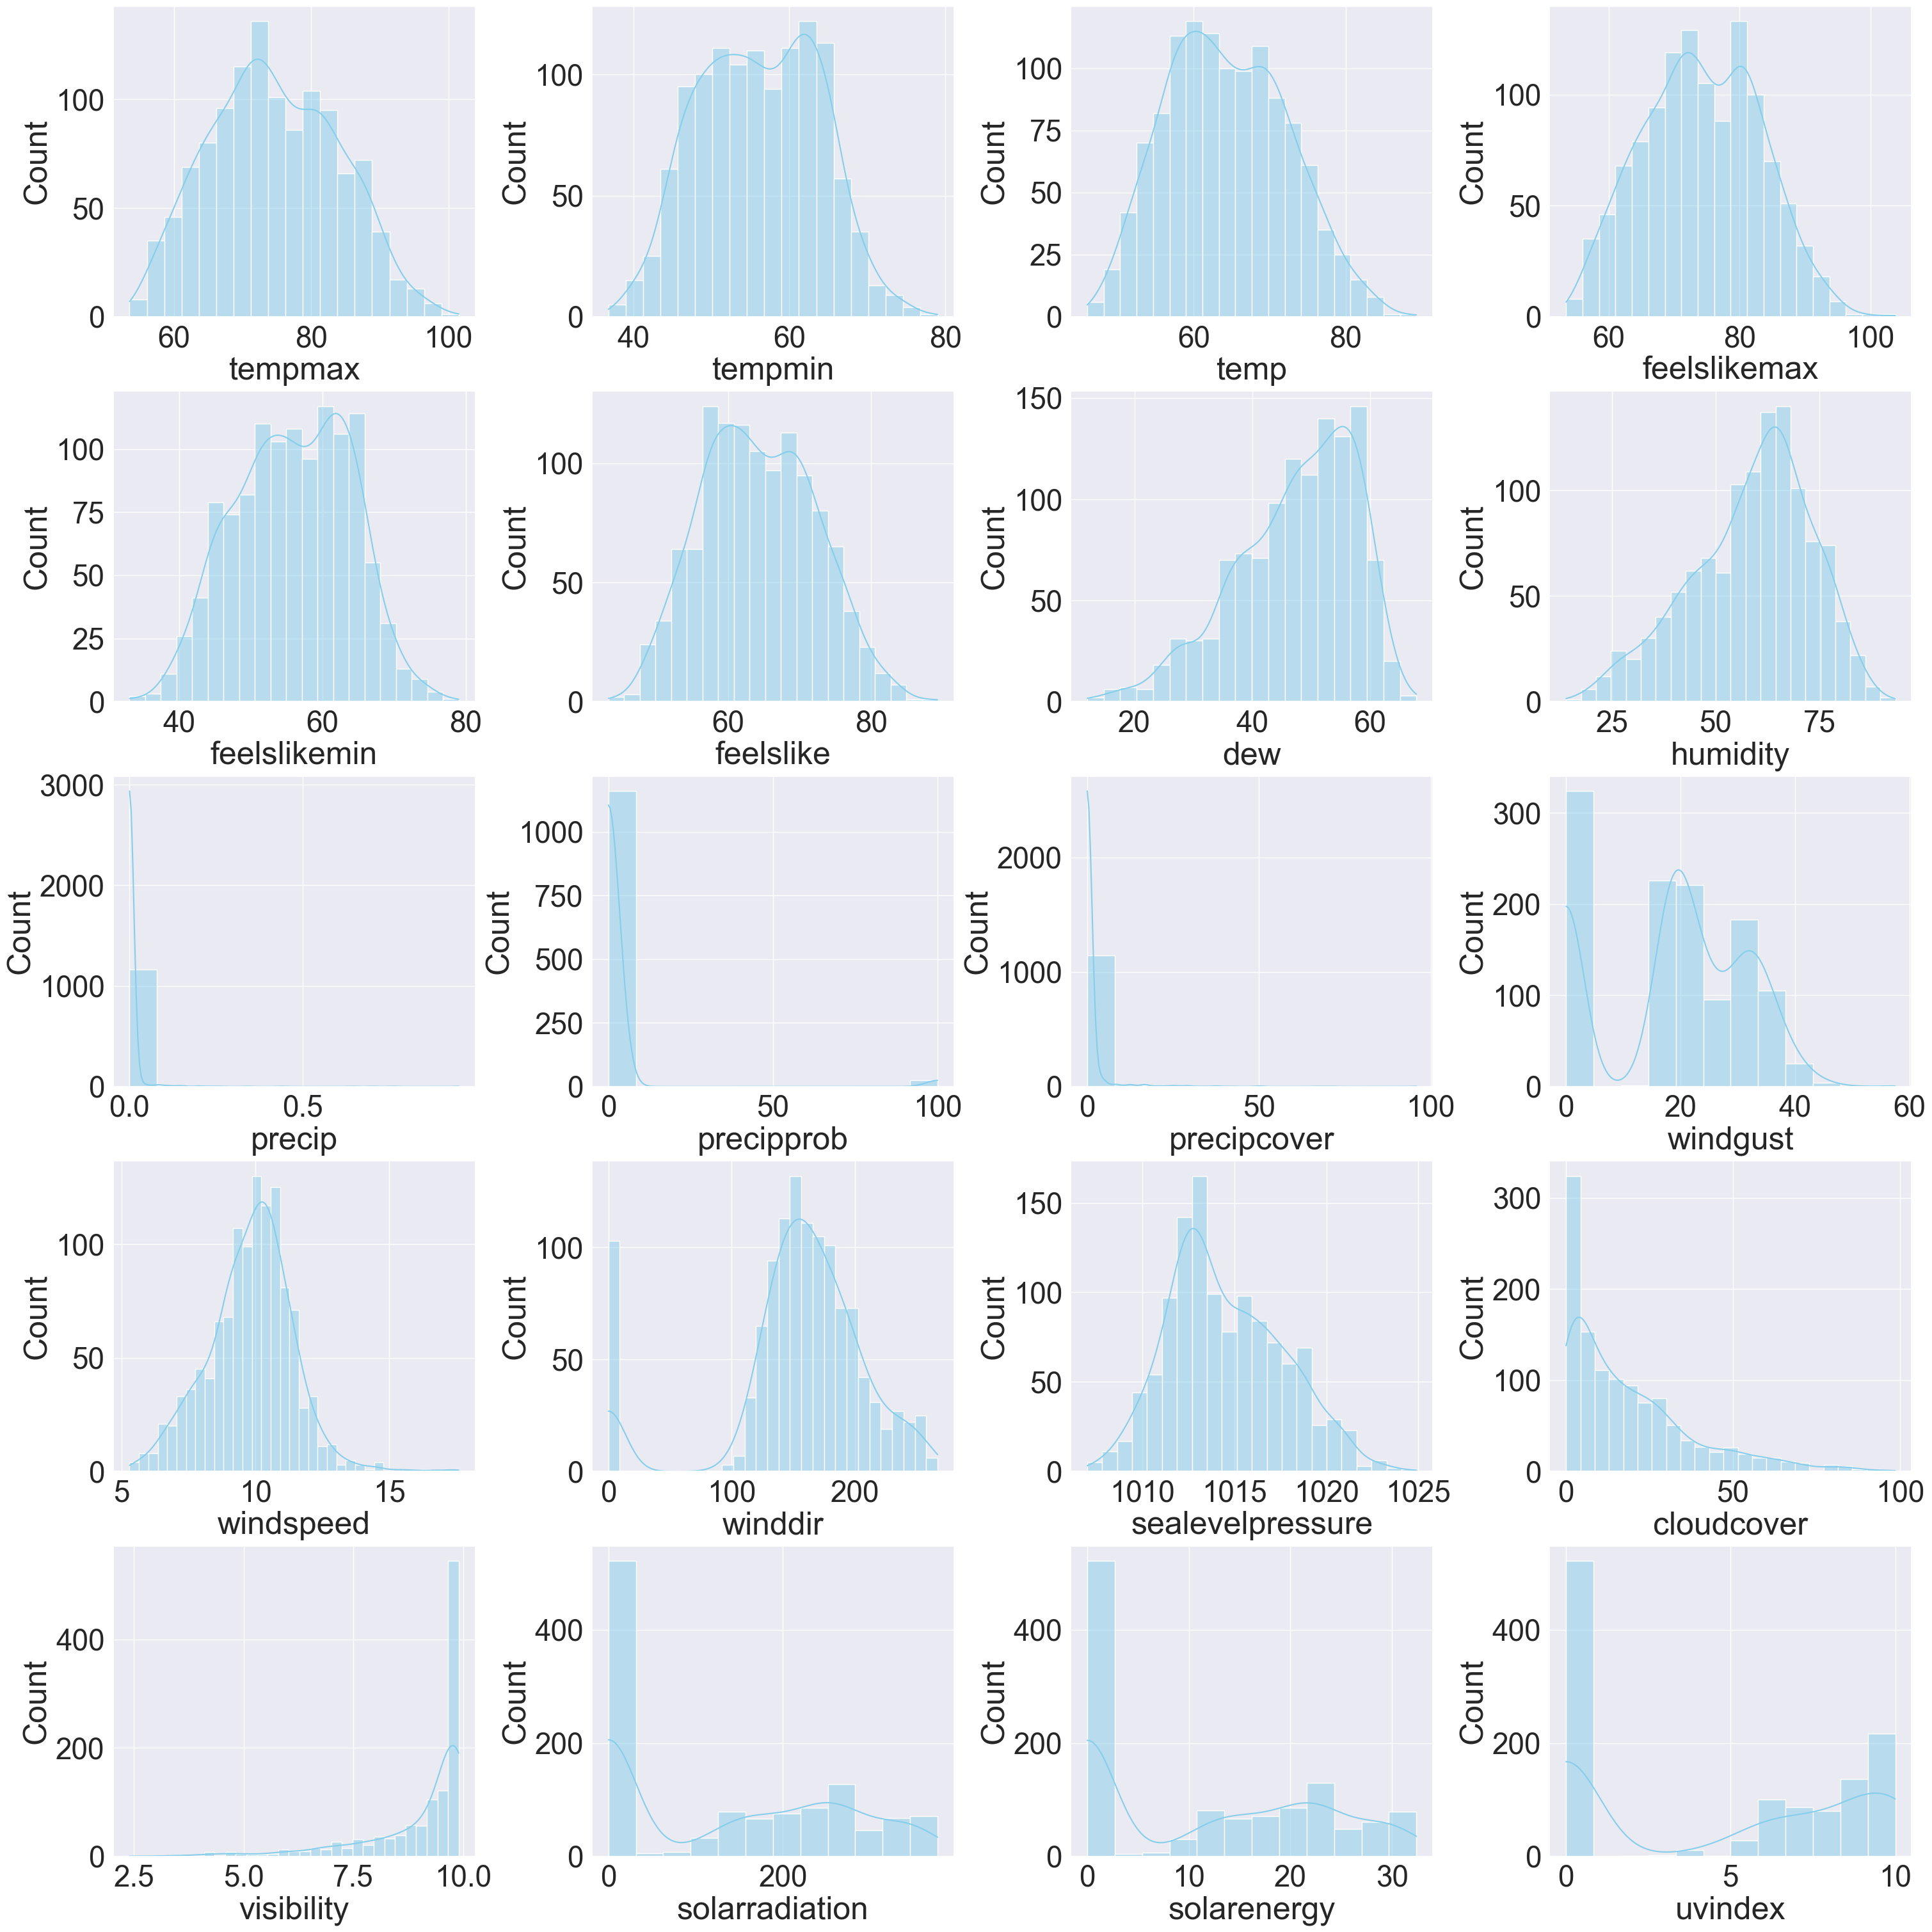

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.set(font_scale=3)

num_row_plots = 5
num_col_plots = 4

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.histplot(data = weather_df,
                         x = weather_df.columns[i],
                         kde=True,
                         color="skyblue",
                         ax=axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass
fig.tight_layout(pad=0.01)
plt.show()

del num_row_plots, num_col_plots, fig, axs, i

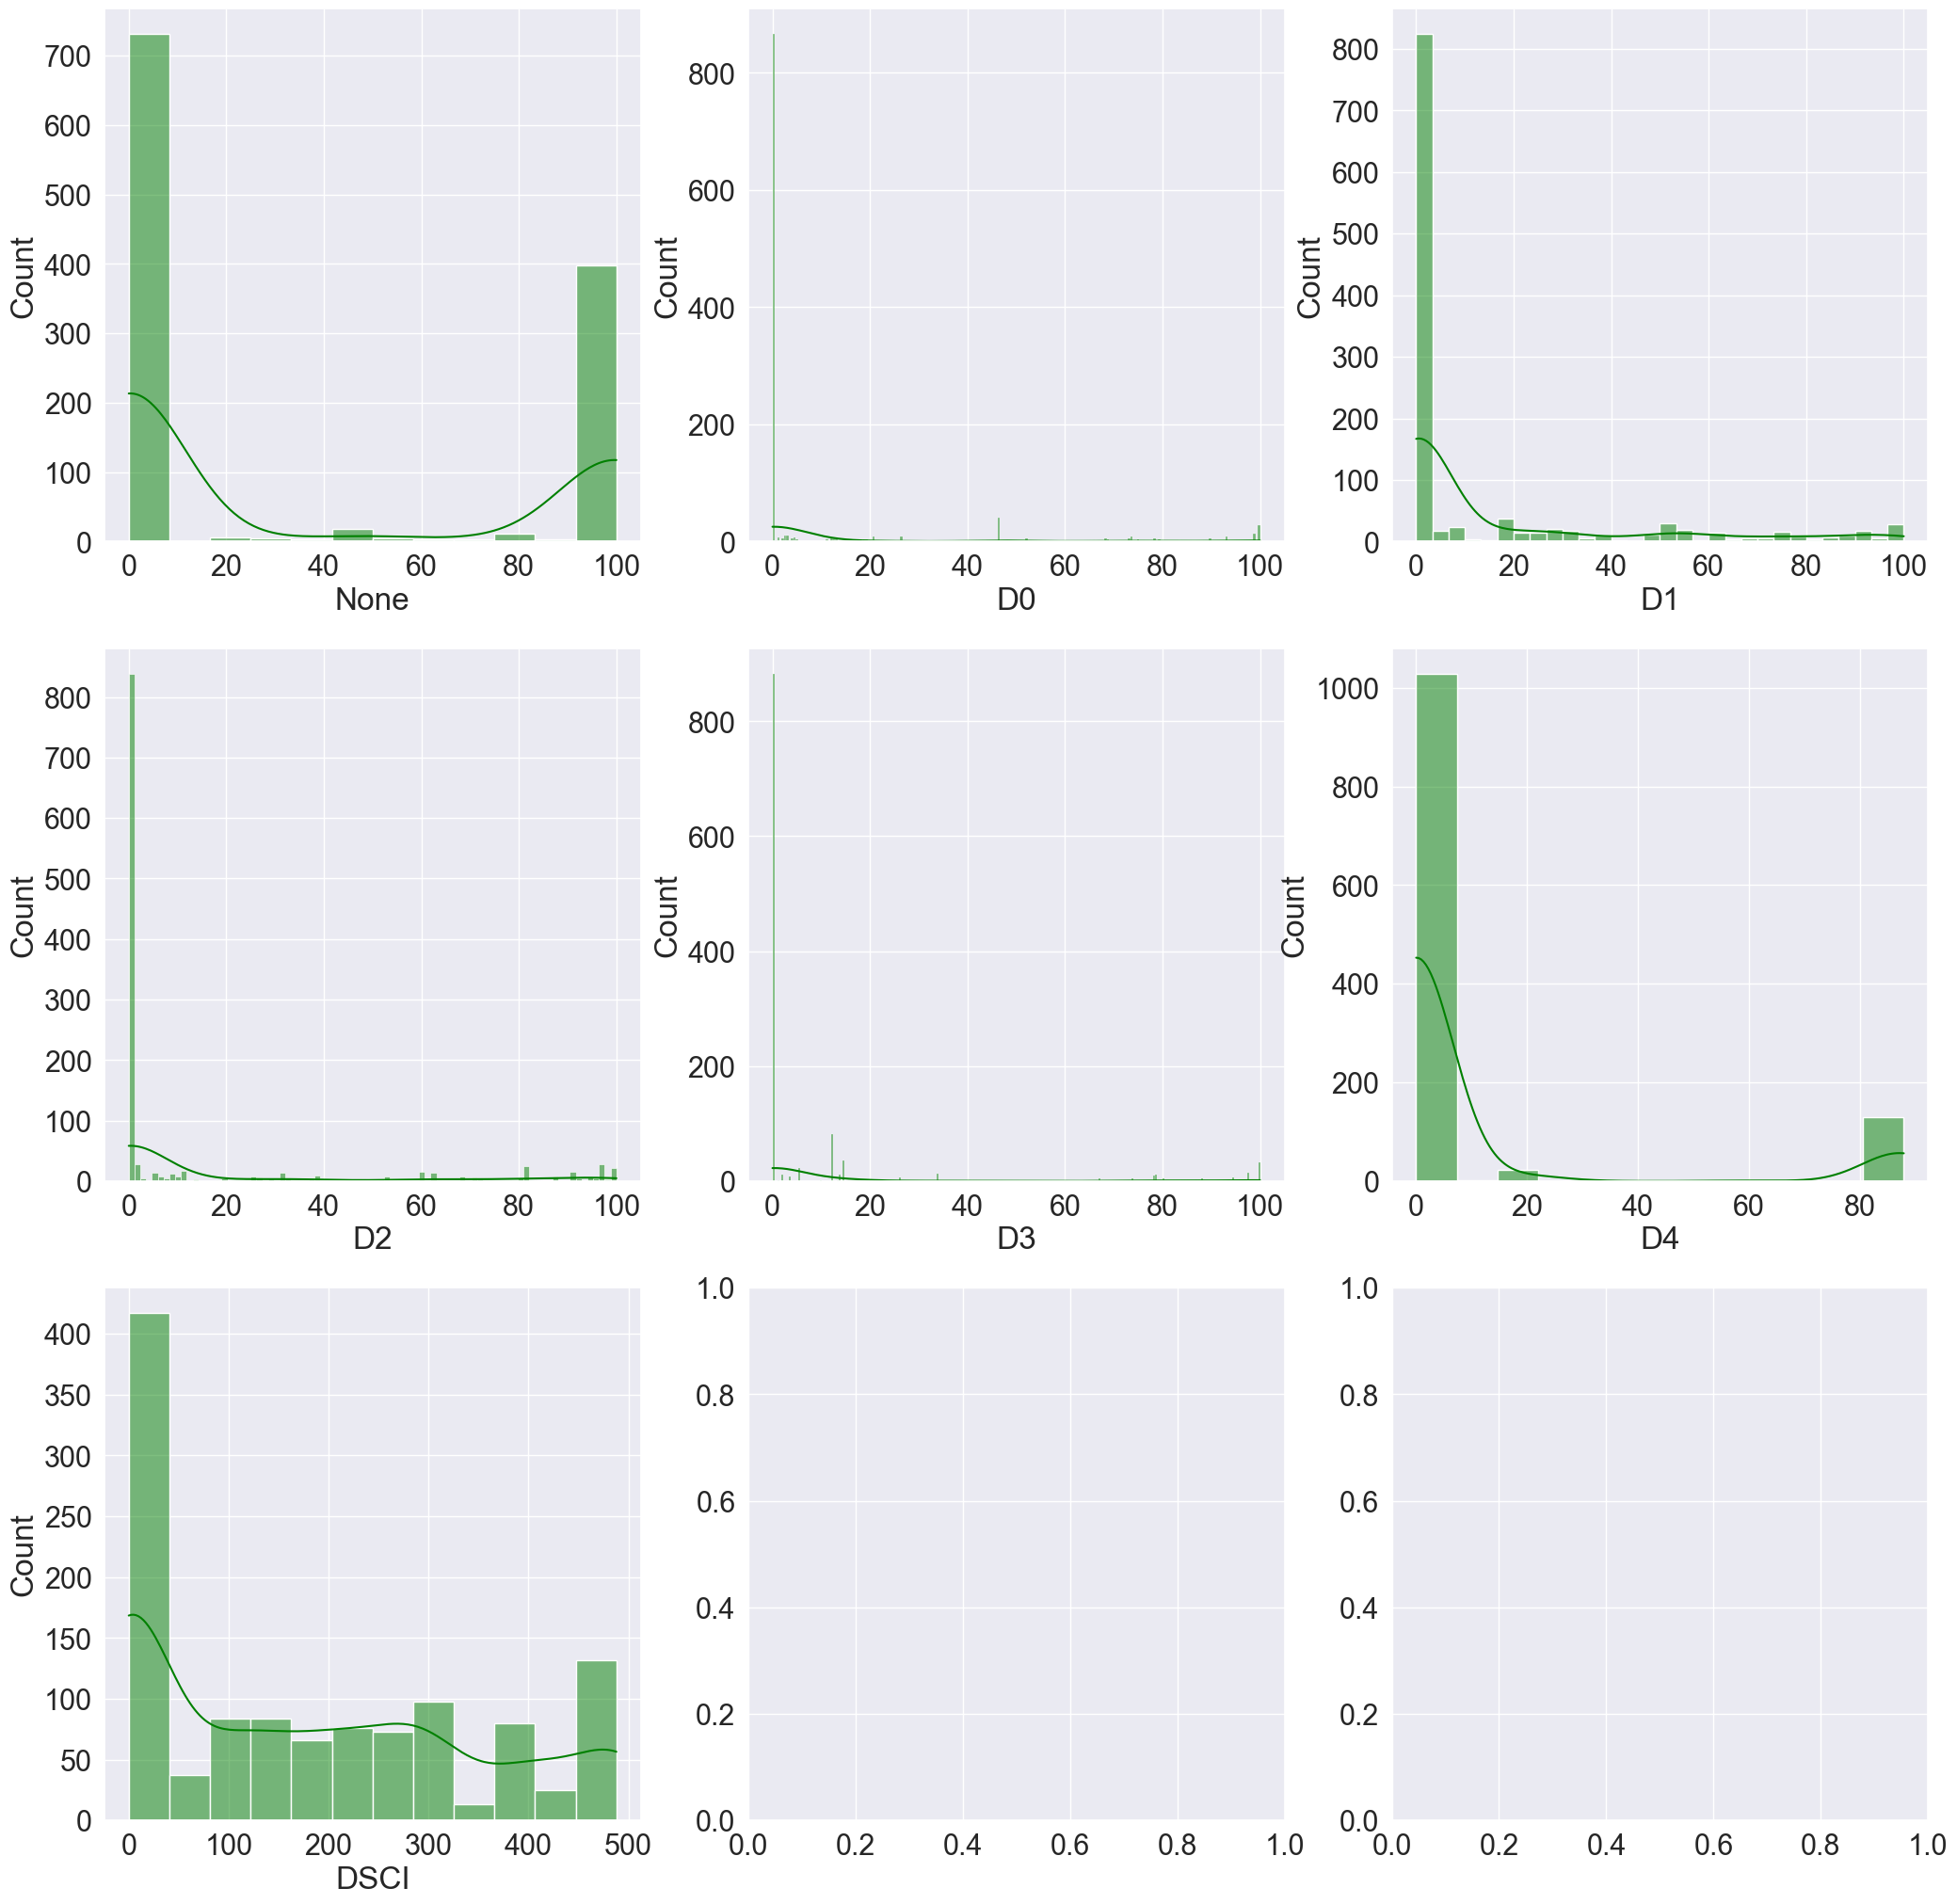

In [15]:
sns.set(style="darkgrid")
sns.set(font_scale=2)

num_row_plots = 3
num_col_plots = 3

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(25,25))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.histplot(data = drought_df,
                         x = drought_df.columns[i],
                         kde=True,
                         color="green",
                         ax=axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass

plt.show()

del num_row_plots, num_col_plots, fig, axs, i

## Choose DSCI as target variable and combine datasets

In [16]:
df_main = pd.concat([weather_df, drought_df["DSCI"]], axis=1, join="inner")
del weather_df, drought_df
df_main

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
2000-01-04     67.4     46.2  55.6          67.4          46.2       55.4   
2000-01-11     63.7     45.0  54.9          63.7          45.0       54.9   
2000-01-18     74.0     58.2  62.2          74.0          58.2       62.2   
2000-01-25     63.4     55.7  58.5          63.4          55.7       58.5   
2000-02-01     65.5     49.2  55.7          65.5          49.2       55.6   
...             ...      ...   ...           ...           ...        ...   
2022-08-16     94.3     70.3  81.4          91.3          70.3       80.3   
2022-08-23     87.1     67.6  76.0          86.5          67.6       75.4   
2022-08-30     89.4     68.2  76.9          89.7          68.2       76.7   
2022-09-06    101.5     79.0  89.3         103.8          79.0       89.3   
2022-09-13     88.9     74.0  80.7          91.4          74.0       81.7   

             dew  humidity  precip  precipprob  ...  windspeed  winddir  \
2000-01-04  34.9     48.58     0.0         0.0  ...        9.2    195.2   
2000-01-11  36.7     58.03     0.0         0.0  ...        7.3    178.8   
2000-01-18  51.7     70.43     0.0         0.0  ...        6.5    167.1   
2000-01-25  53.6     83.09     0.0         0.0  ...        8.9    196.8   
2000-02-01  46.3     65.99     0.0         0.0  ...        8.1    177.3   
...          ...       ...     ...         ...  ...        ...      ...   
2022-08-16  52.4     37.30     0.0         0.0  ...       10.1    134.6   
2022-08-23  61.7     62.70     0.0         0.0  ...       10.0    146.6   
2022-08-30  60.7     62.80     0.0         0.0  ...       10.5    153.2   
2022-09-06  61.4     41.10     0.0         0.0  ...       10.9    152.7   
2022-09-13  63.3     62.10     0.0         0.0  ...       10.7    154.9   

            sealevelpressure  cloudcover  visibility  solarradiation  \
2000-01-04            1024.9        12.0         9.8             0.0   
2000-01-11            1020.9        19.5         7.7             0.0   
2000-01-18            1020.2        25.3         8.0             0.0   
2000-01-25            1018.5        26.7         7.0             0.0   
2000-02-01            1020.7        14.2         7.7             0.0   
...                      ...         ...         ...             ...   
2022-08-16            1012.1         0.0         9.9           260.0   
2022-08-23            1010.7         3.9         9.8           253.8   
2022-08-30            1011.1         7.1         9.8           253.3   
2022-09-06            1008.8         0.3         9.9           259.0   
2022-09-13            1010.3        18.3         9.9           170.8   

            solarenergy  uvindex  moonphase  DSCI  
2000-01-04          0.0      0.0       0.98   100  
2000-01-11          0.0      0.0       0.06   100  
2000-01-18          0.0      0.0       0.30   100  
2000-01-25          0.0      0.0       0.52   100  
2000-02-01          0.0      0.0       0.81   100  
...                 ...      ...        ...   ...  
2022-08-16         22.6      9.0       0.52   323  
2022-08-23         21.9      9.0       0.82   323  
2022-08-30         21.8      9.0       0.05   323  
2022-09-06         22.3      9.0       0.24   323  
2022-09-13         14.8      7.0       0.50   323  

[1185 rows x 22 columns]

## Correlation Heatmap

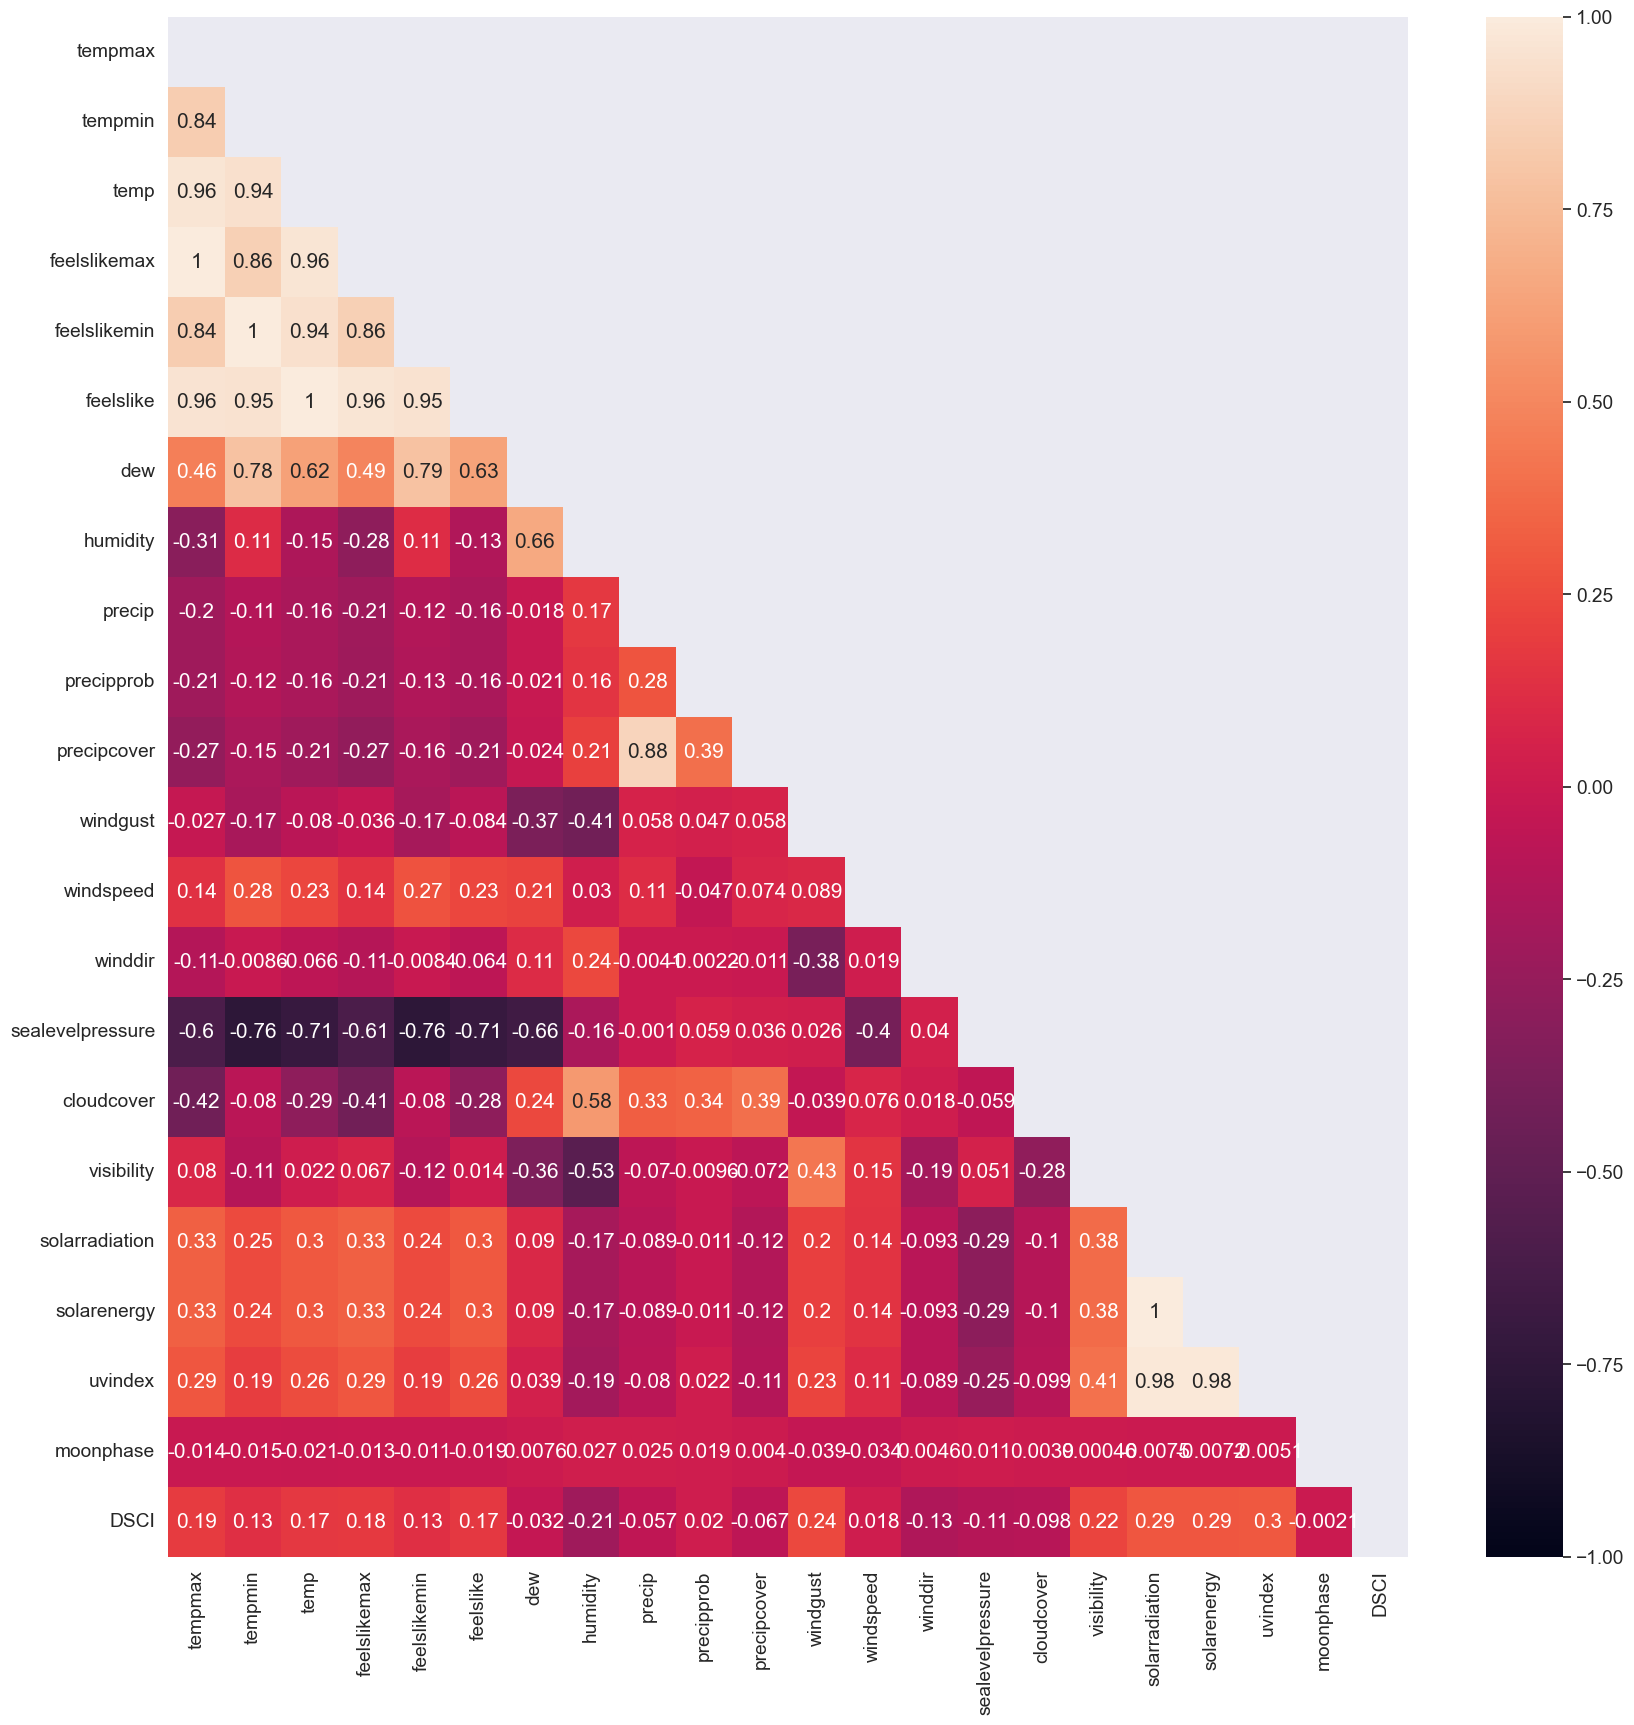

In [17]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.25)
mask = np.triu(np.ones_like(df_main.corr(), dtype=bool))
sns.heatmap(df_main.corr(),annot=True, mask=mask, vmin=-1, vmax=1)
plt.show()

## Covariance Heatmap

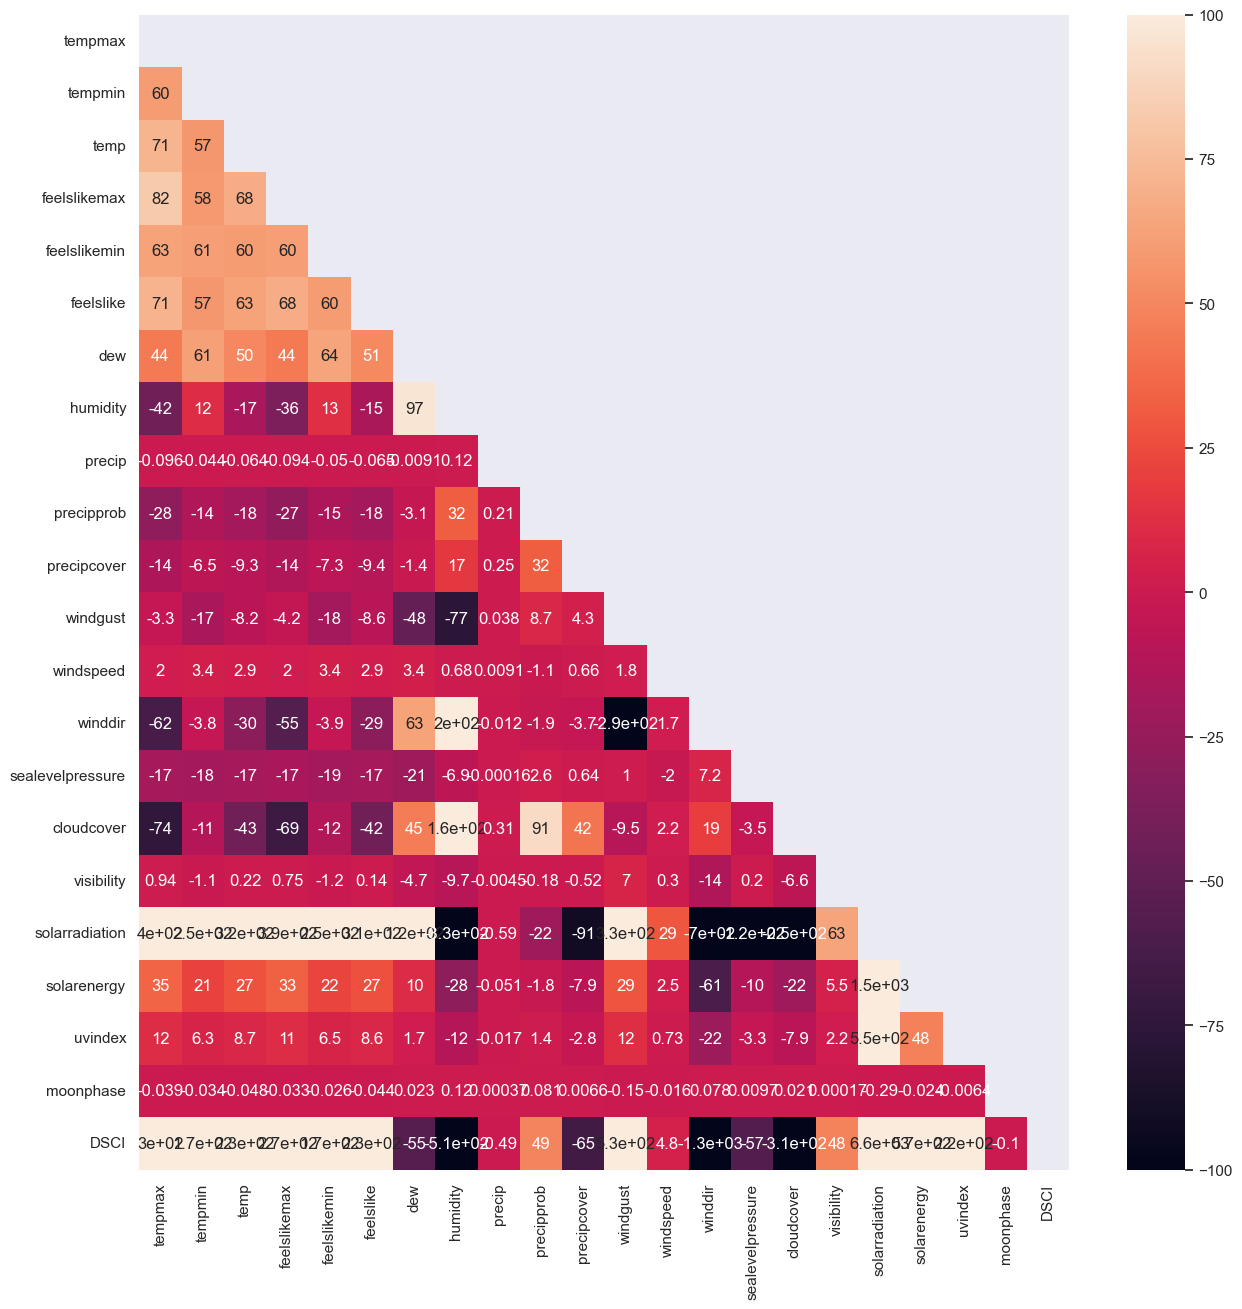

In [18]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
mask = np.triu(np.ones_like(df_main.cov(), dtype=bool))
sns.heatmap(df_main.cov(),annot=True, mask=mask, vmin=-100, vmax=100)
plt.show()
del mask

## Scatterplots to show nonlinear relationships between features and DSCI

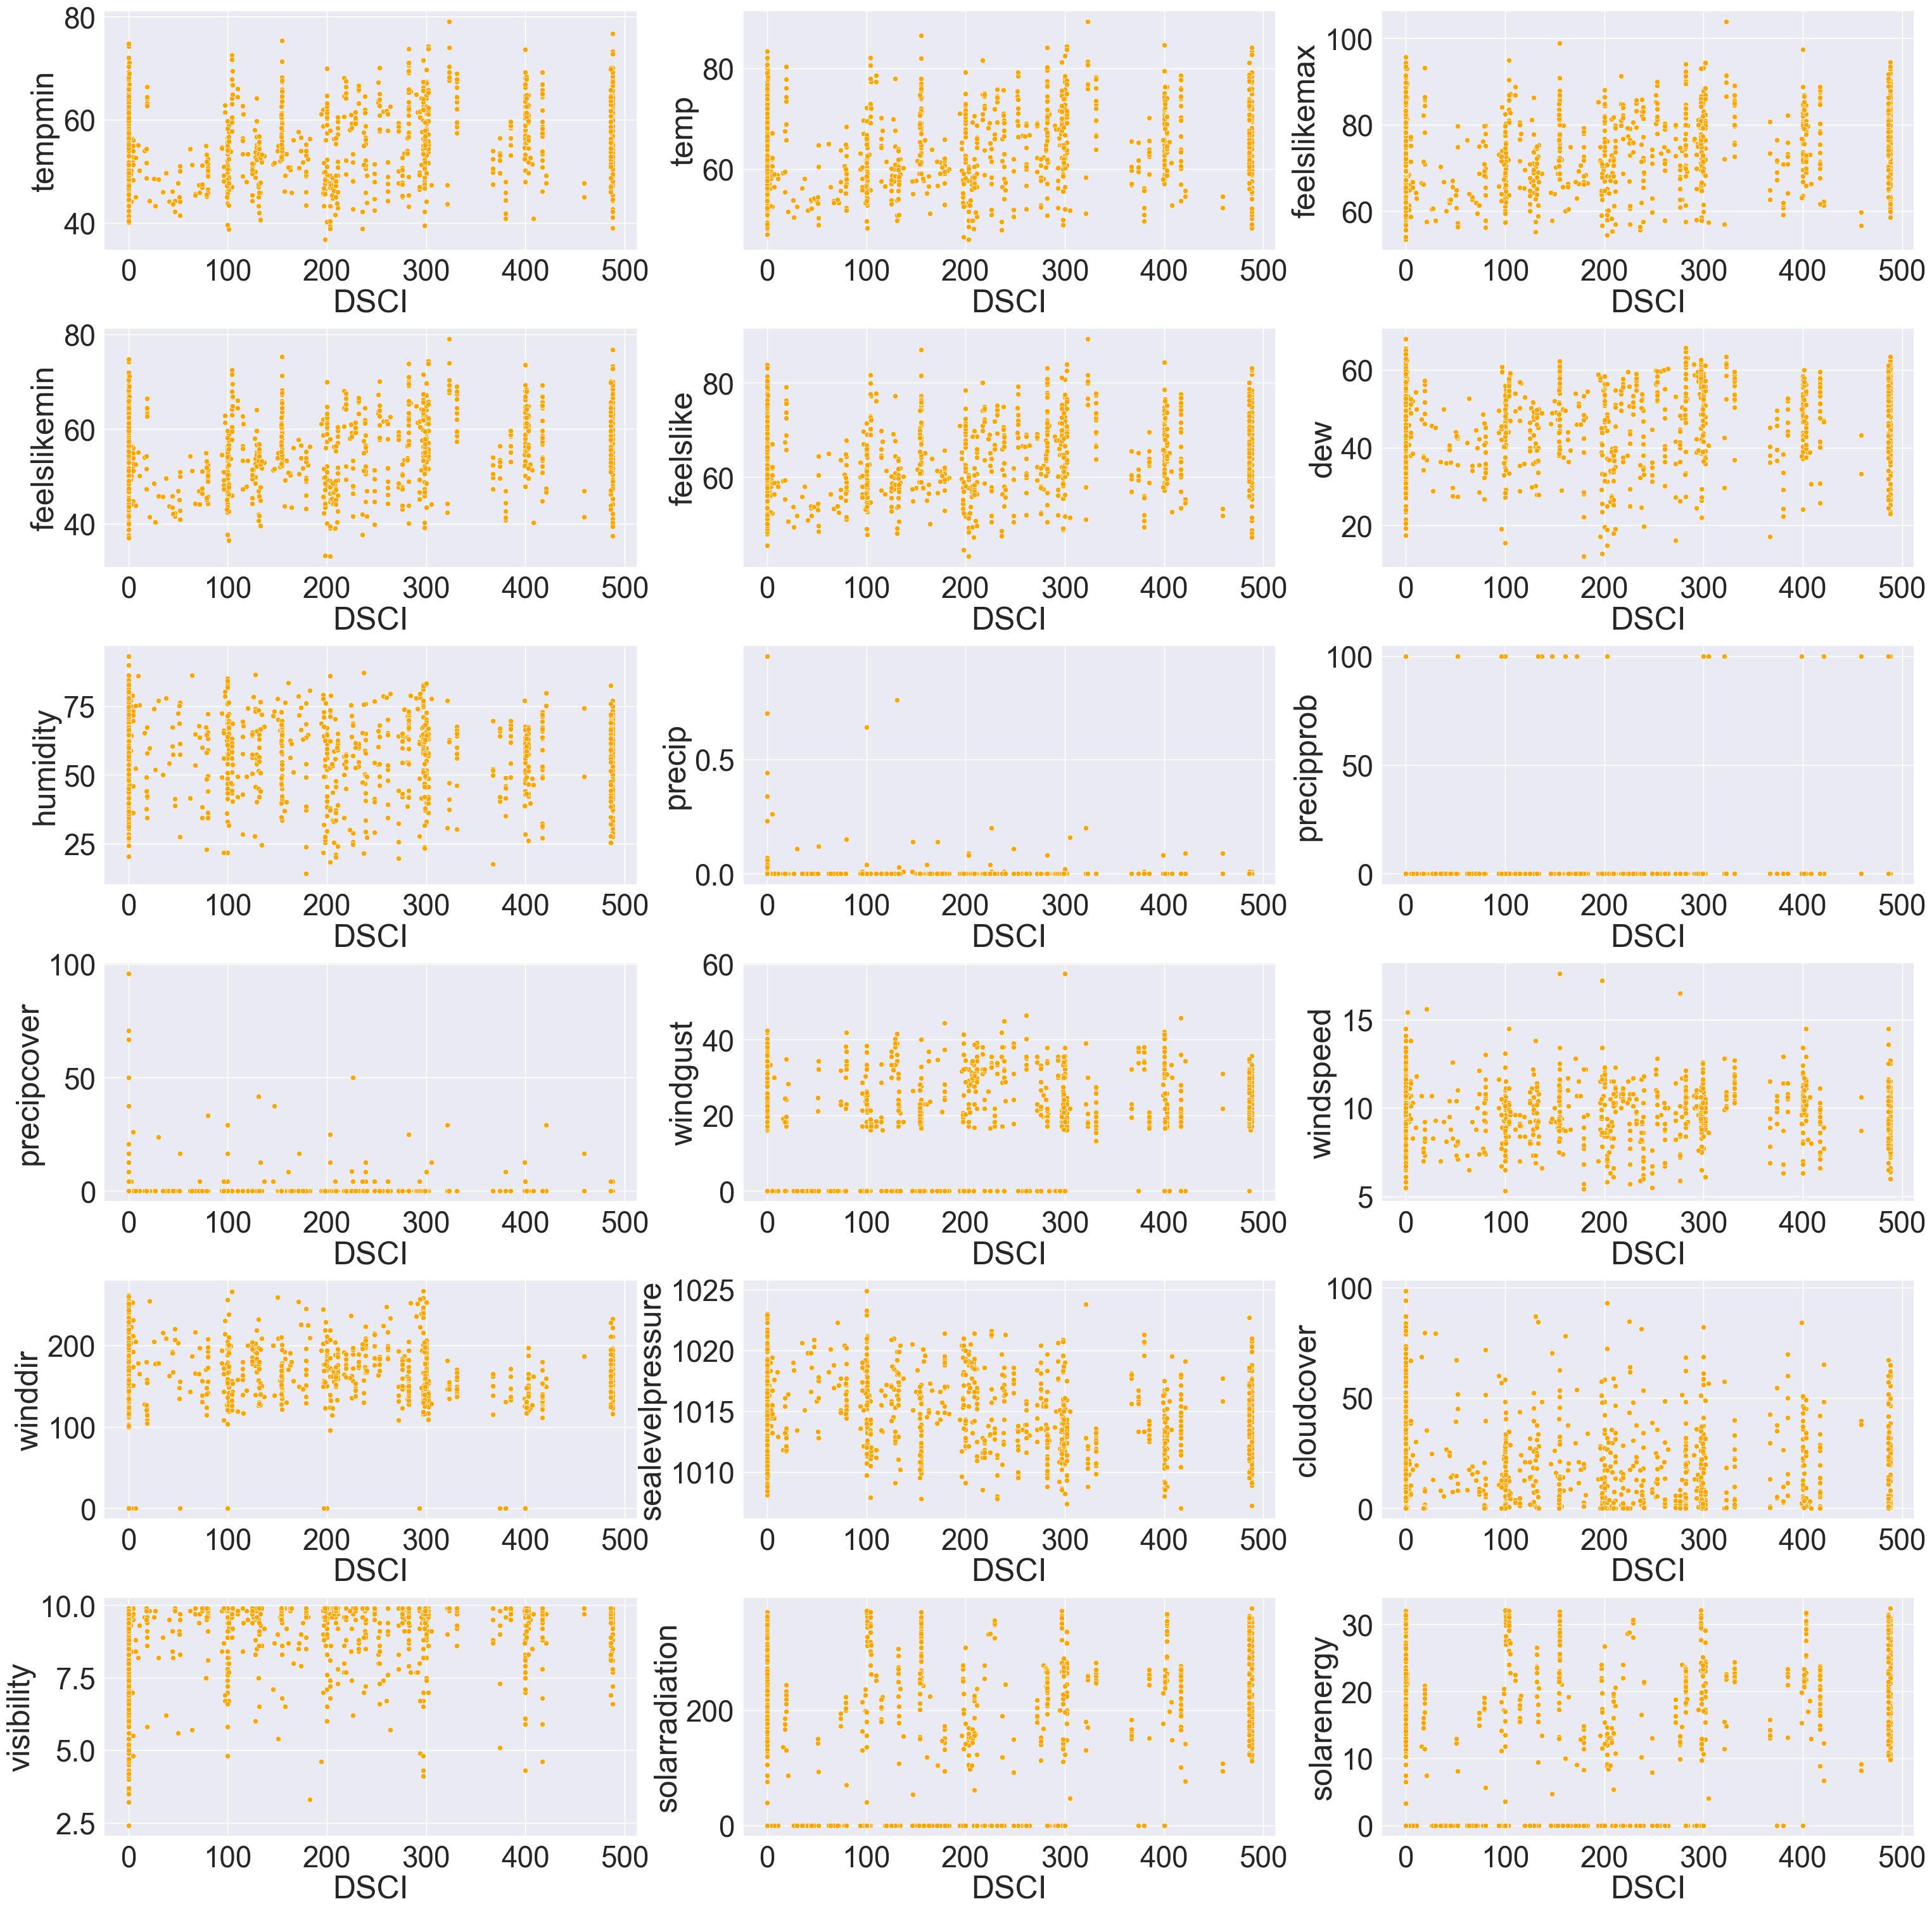

In [19]:
sns.set(style="darkgrid")
sns.set(font_scale=3)

num_row_plots = 6
num_col_plots = 3

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 1
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.scatterplot(data = df_main,
                             x = "DSCI",
                             y = df_main.columns[i],
                             color = "orange",
                             ax = axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass
fig.tight_layout(pad=0.01)
plt.show()


del num_row_plots, num_col_plots, fig, axs, i

## Boxplots to show value ranges for all features

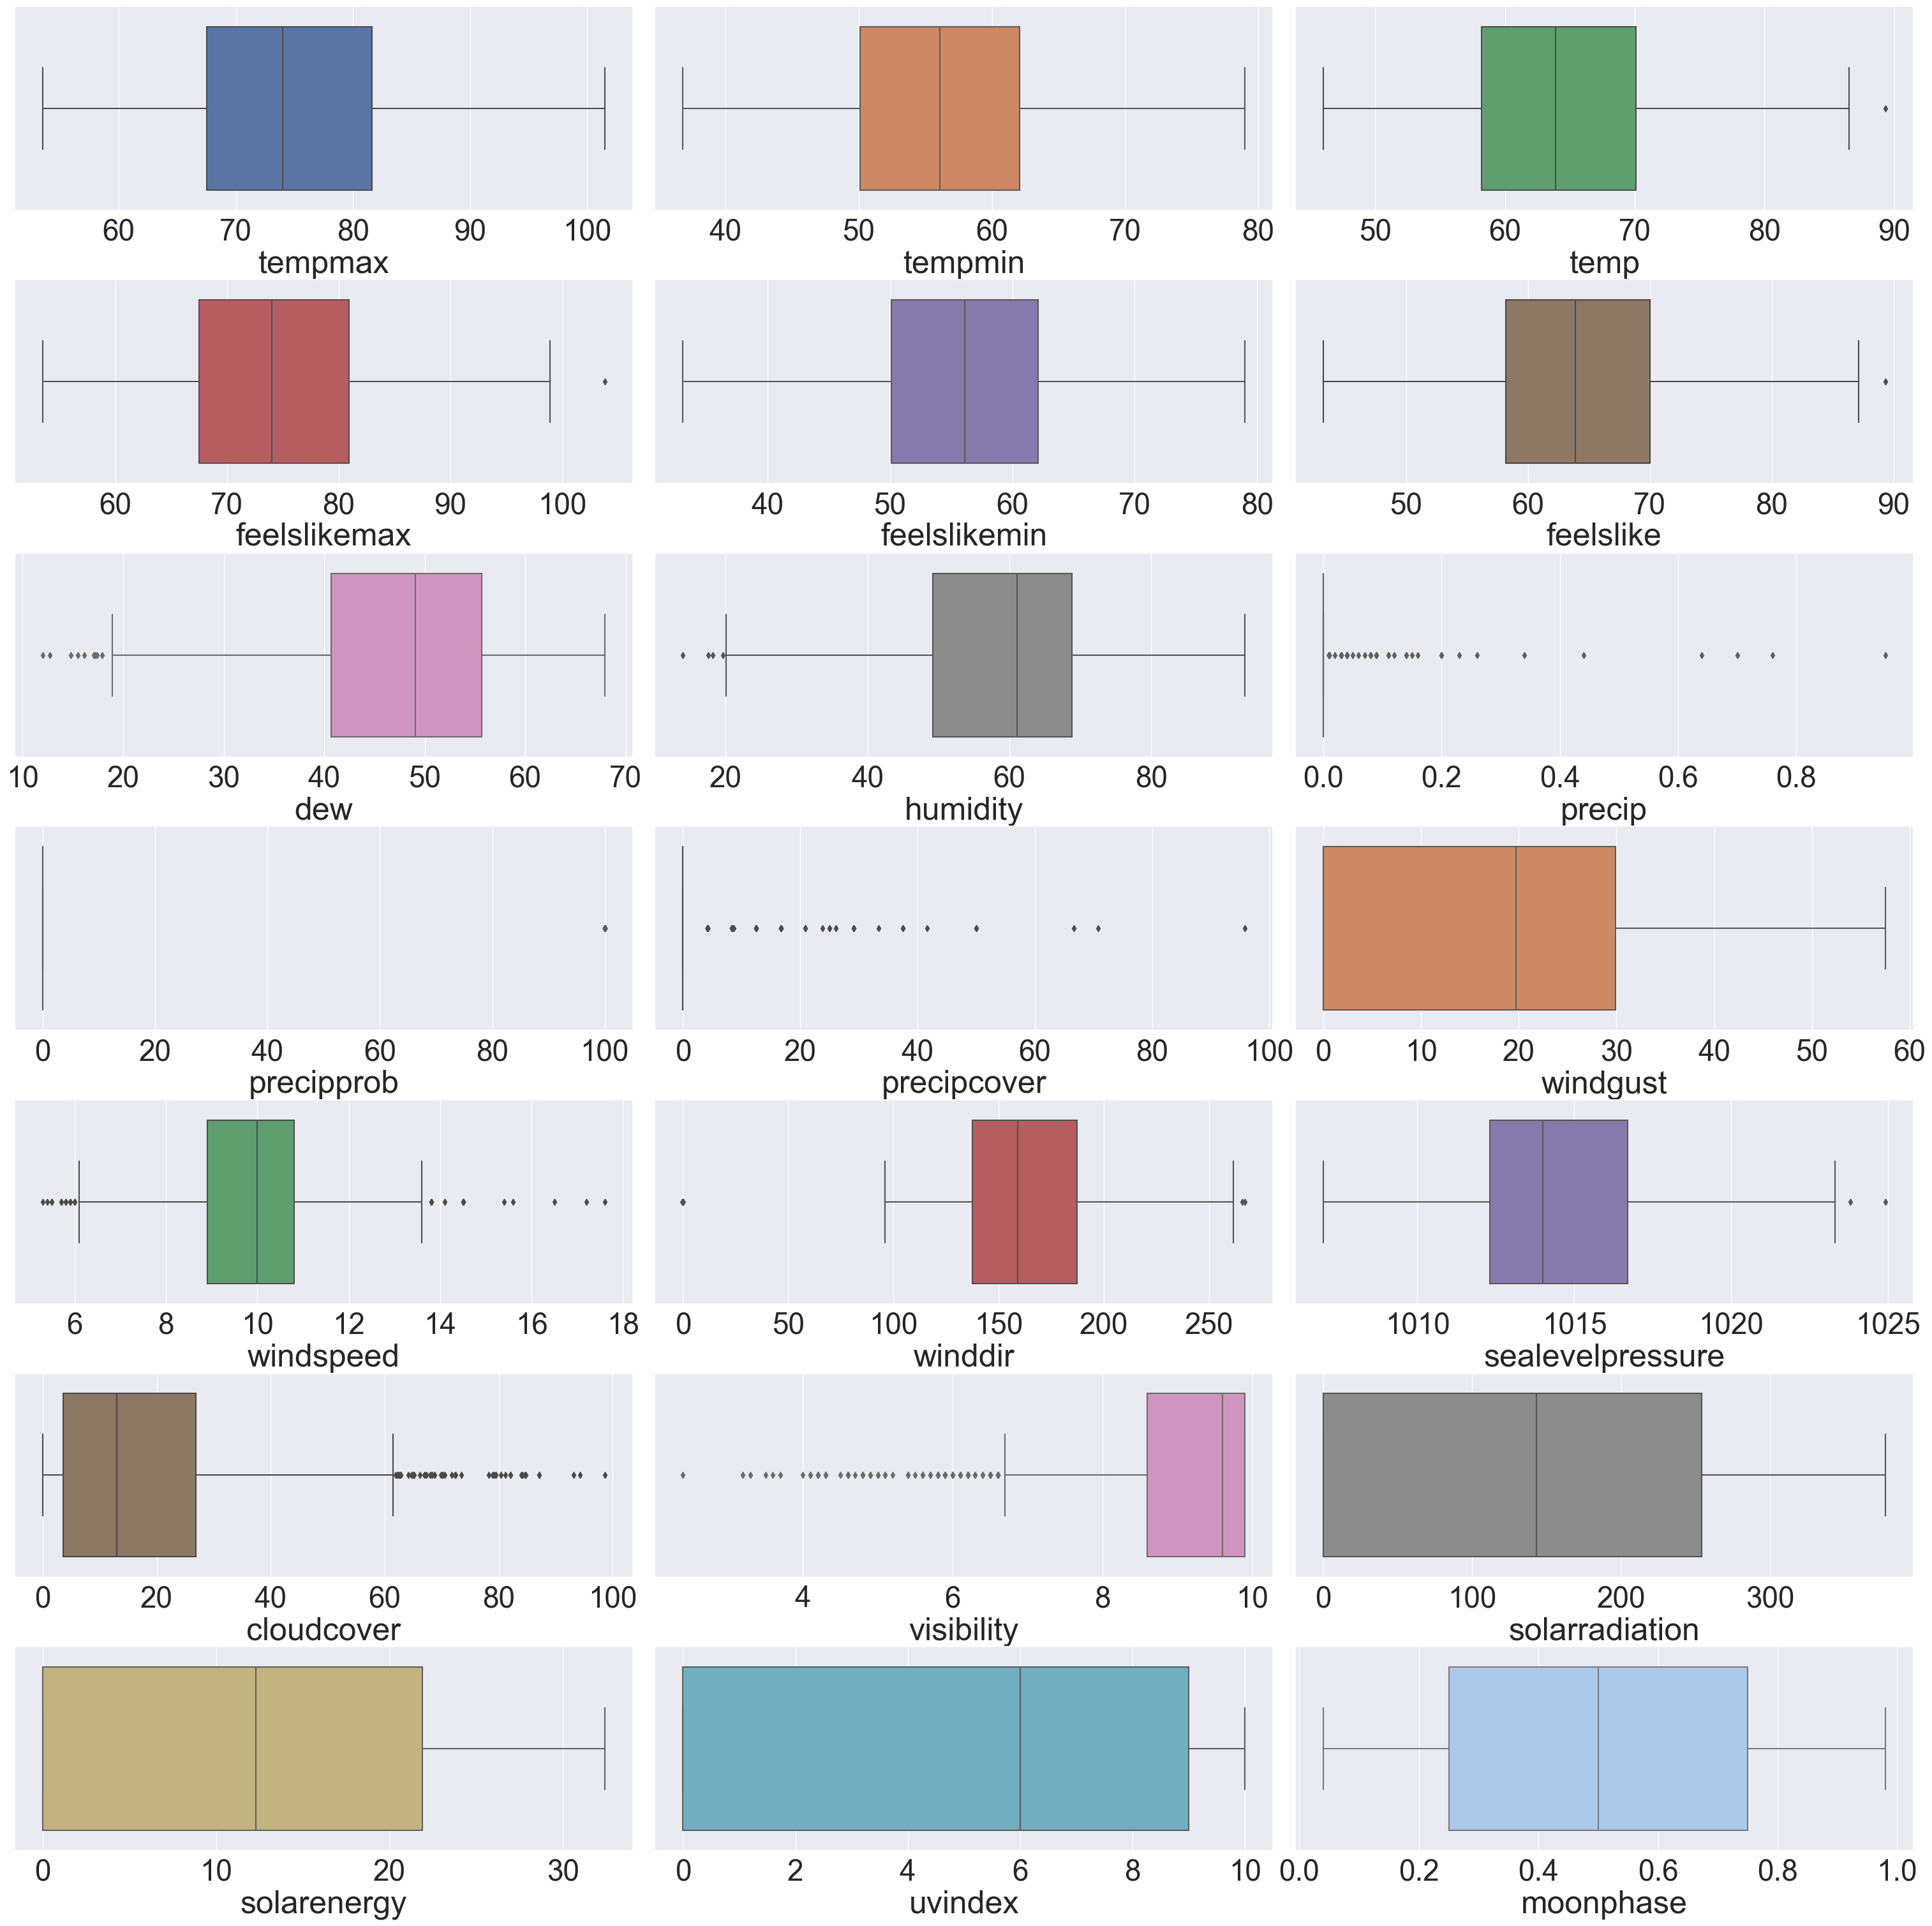

In [20]:
sns.set(style="darkgrid")
sns.set(font_scale=3)


num_row_plots = 7
num_col_plots = 3
colors = (list(sns.color_palette().as_hex())  
         + list(sns.color_palette('deep').as_hex())
         + list(sns.color_palette('pastel').as_hex()))

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.boxplot(data = df_main, 
                           x = df_main.columns[i],
                           ax = axs[row_plot, col_plot],
                           color = colors[i])
            i += 1
        except Exception as e:
            pass
        
        
fig.tight_layout(pad=0.01)
plt.show()

del colors, num_row_plots, num_col_plots, fig, axs, i

## Violinplots to show value distributions for all features

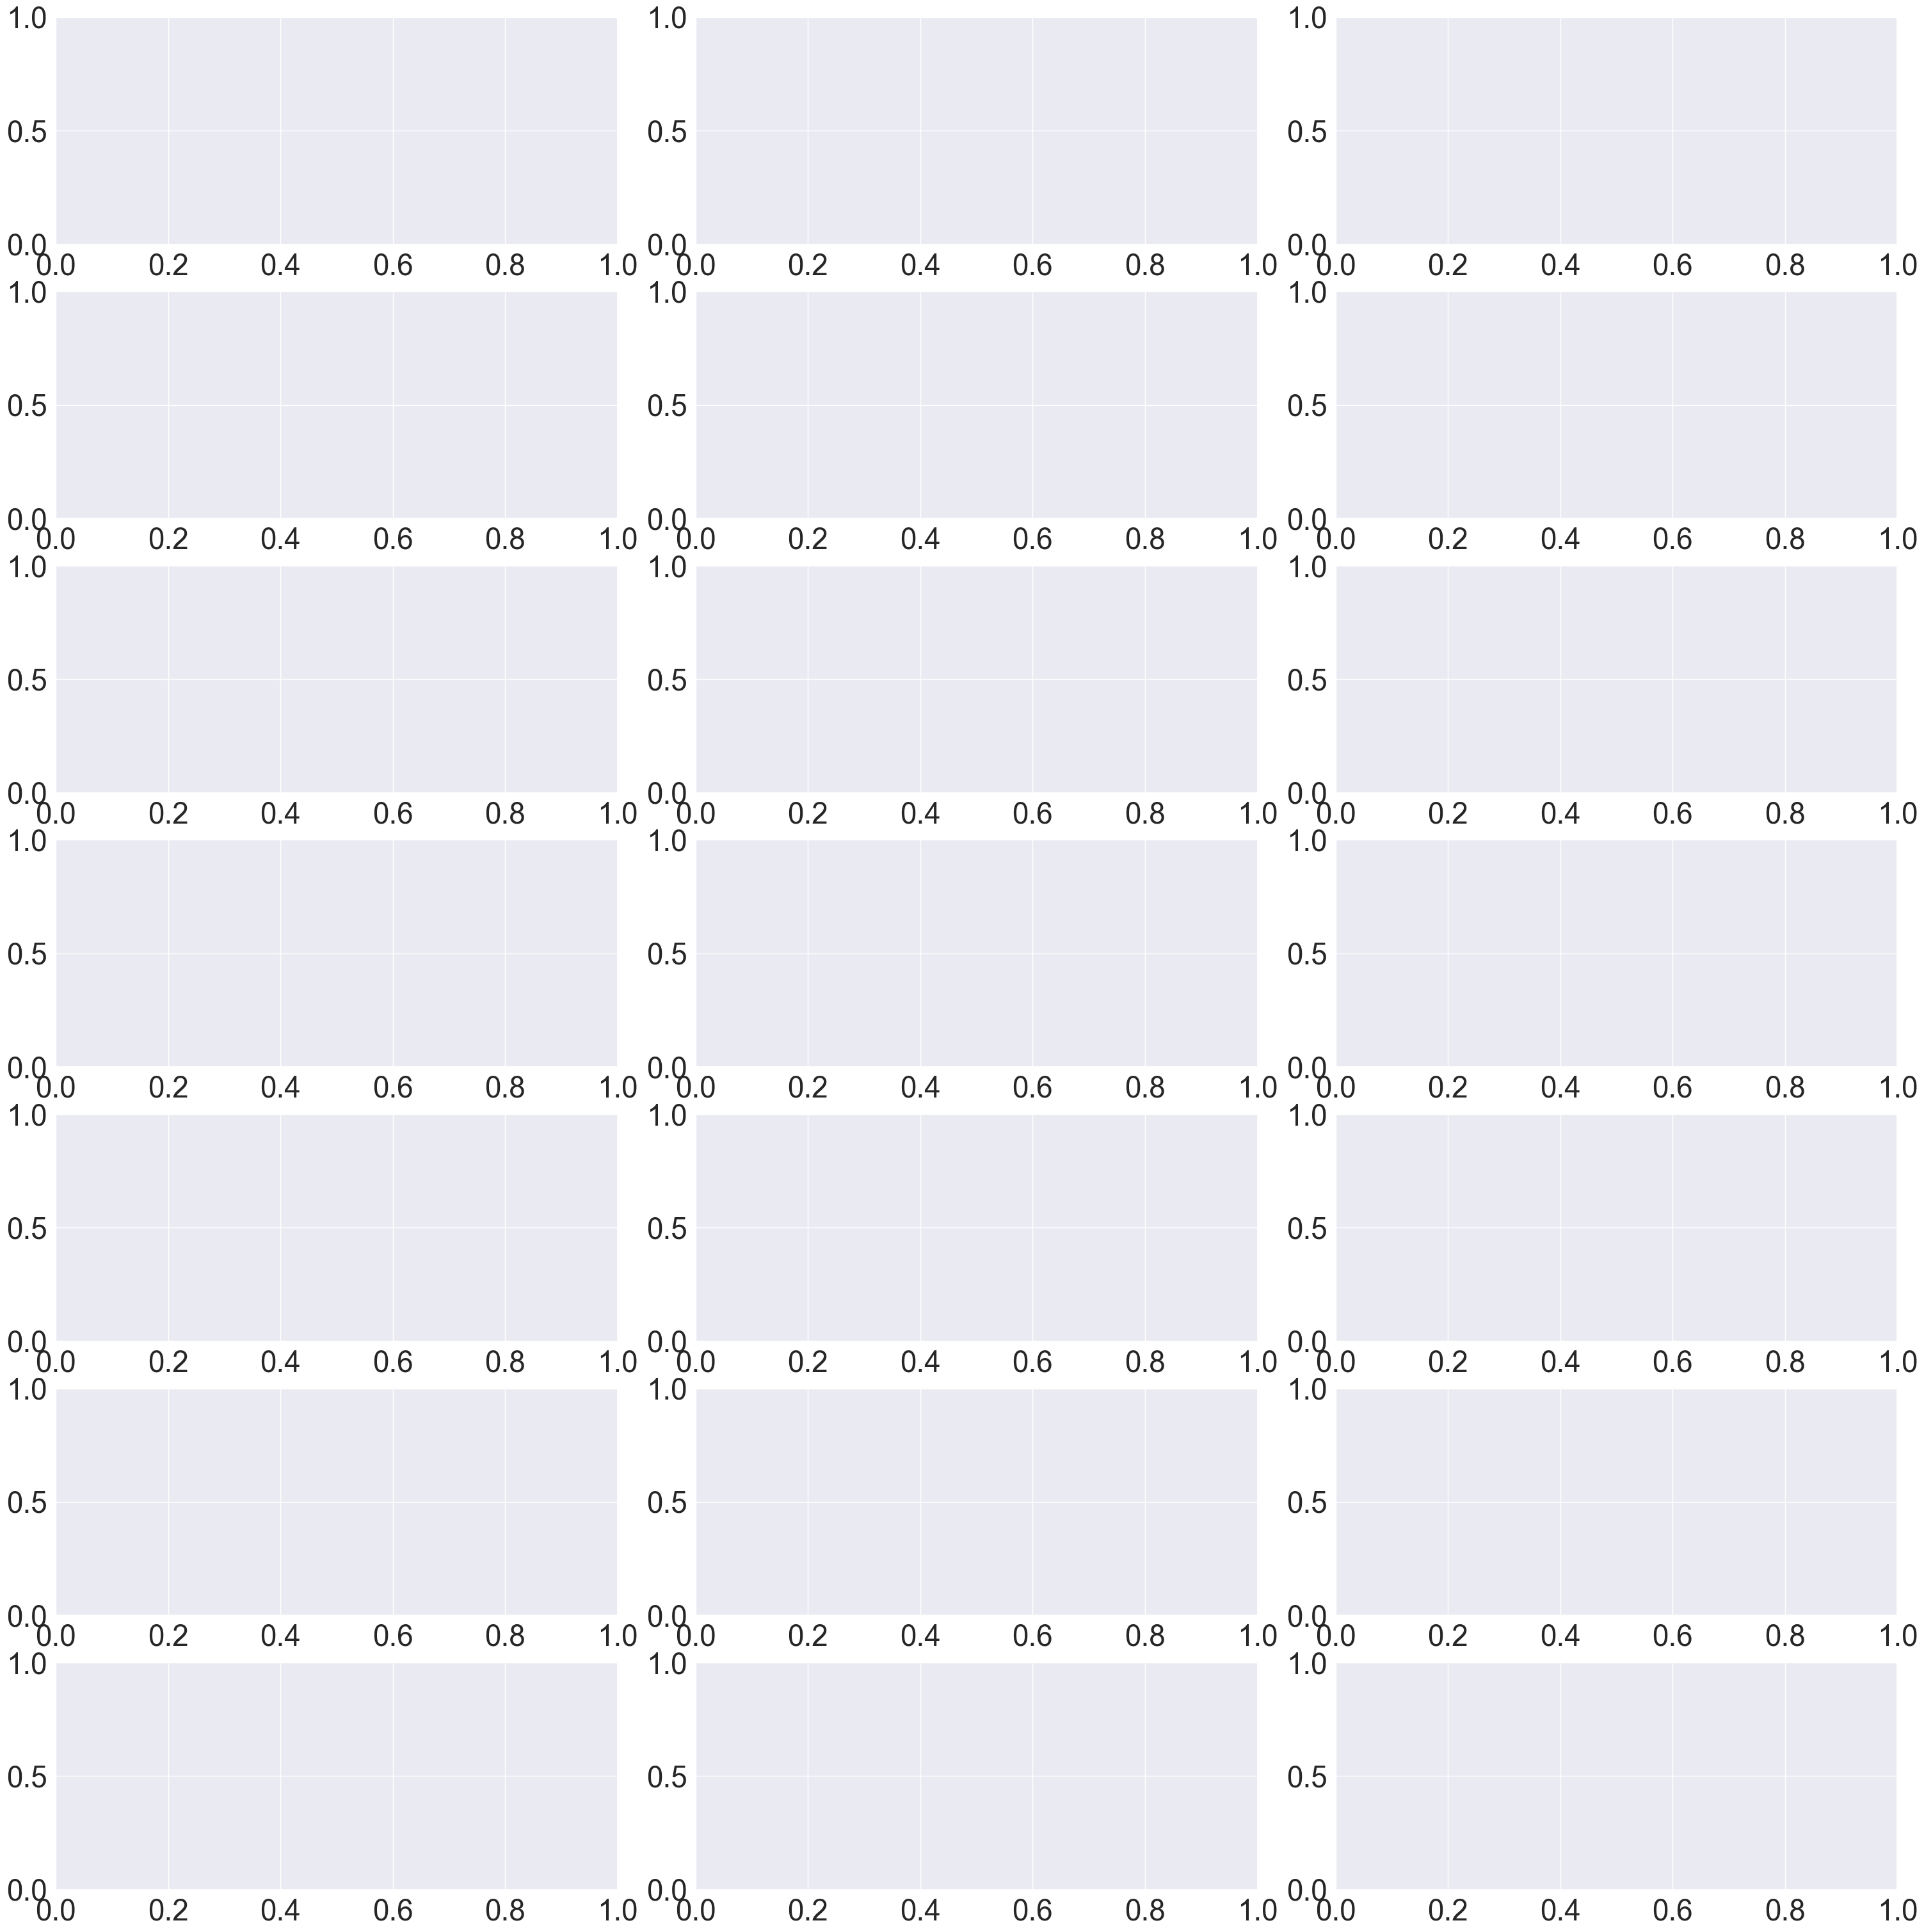

In [21]:
sns.set(style="darkgrid")
sns.set(font_scale=3)


num_row_plots = 7
num_col_plots = 3
colors = (list(sns.color_palette().as_hex())  
         + list(sns.color_palette('deep').as_hex())
         + list(sns.color_palette('pastel').as_hex()))

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.violinplot(data = df_main,
                           y = df_main.columns[i],
                           x = "IsDrought",
                           ax = axs[row_plot, col_plot],
                           color = colors[i])
            i += 1
        except Exception as e:
            pass
        
        
fig.tight_layout(pad=0.01)
plt.show()

del colors, num_row_plots, num_col_plots, fig, axs, i

## Replace DSCI with IsDrought binary integer column for classification

In [22]:
df_main['IsDrought'] = df_main.DSCI.apply(lambda x: 1 if x >= 70 else 0)
df_main = df_main.drop(columns='DSCI')

## Use the train_test_split() twice to split the data in 80:10:10 for train:valid:test dataset

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
y = df_main.iloc[:,-1] # Define target dataset as IsDrought column only
X = df_main.iloc[:,:-1] # Define feature dataset as all other columns
del df_main

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state = 42, stratify=y)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 42, stratify=y_rem)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(948, 21)
(948,)
(118, 21)
(118,)
(119, 21)
(119,)


(None, None)

## Examine distributions of all three splits

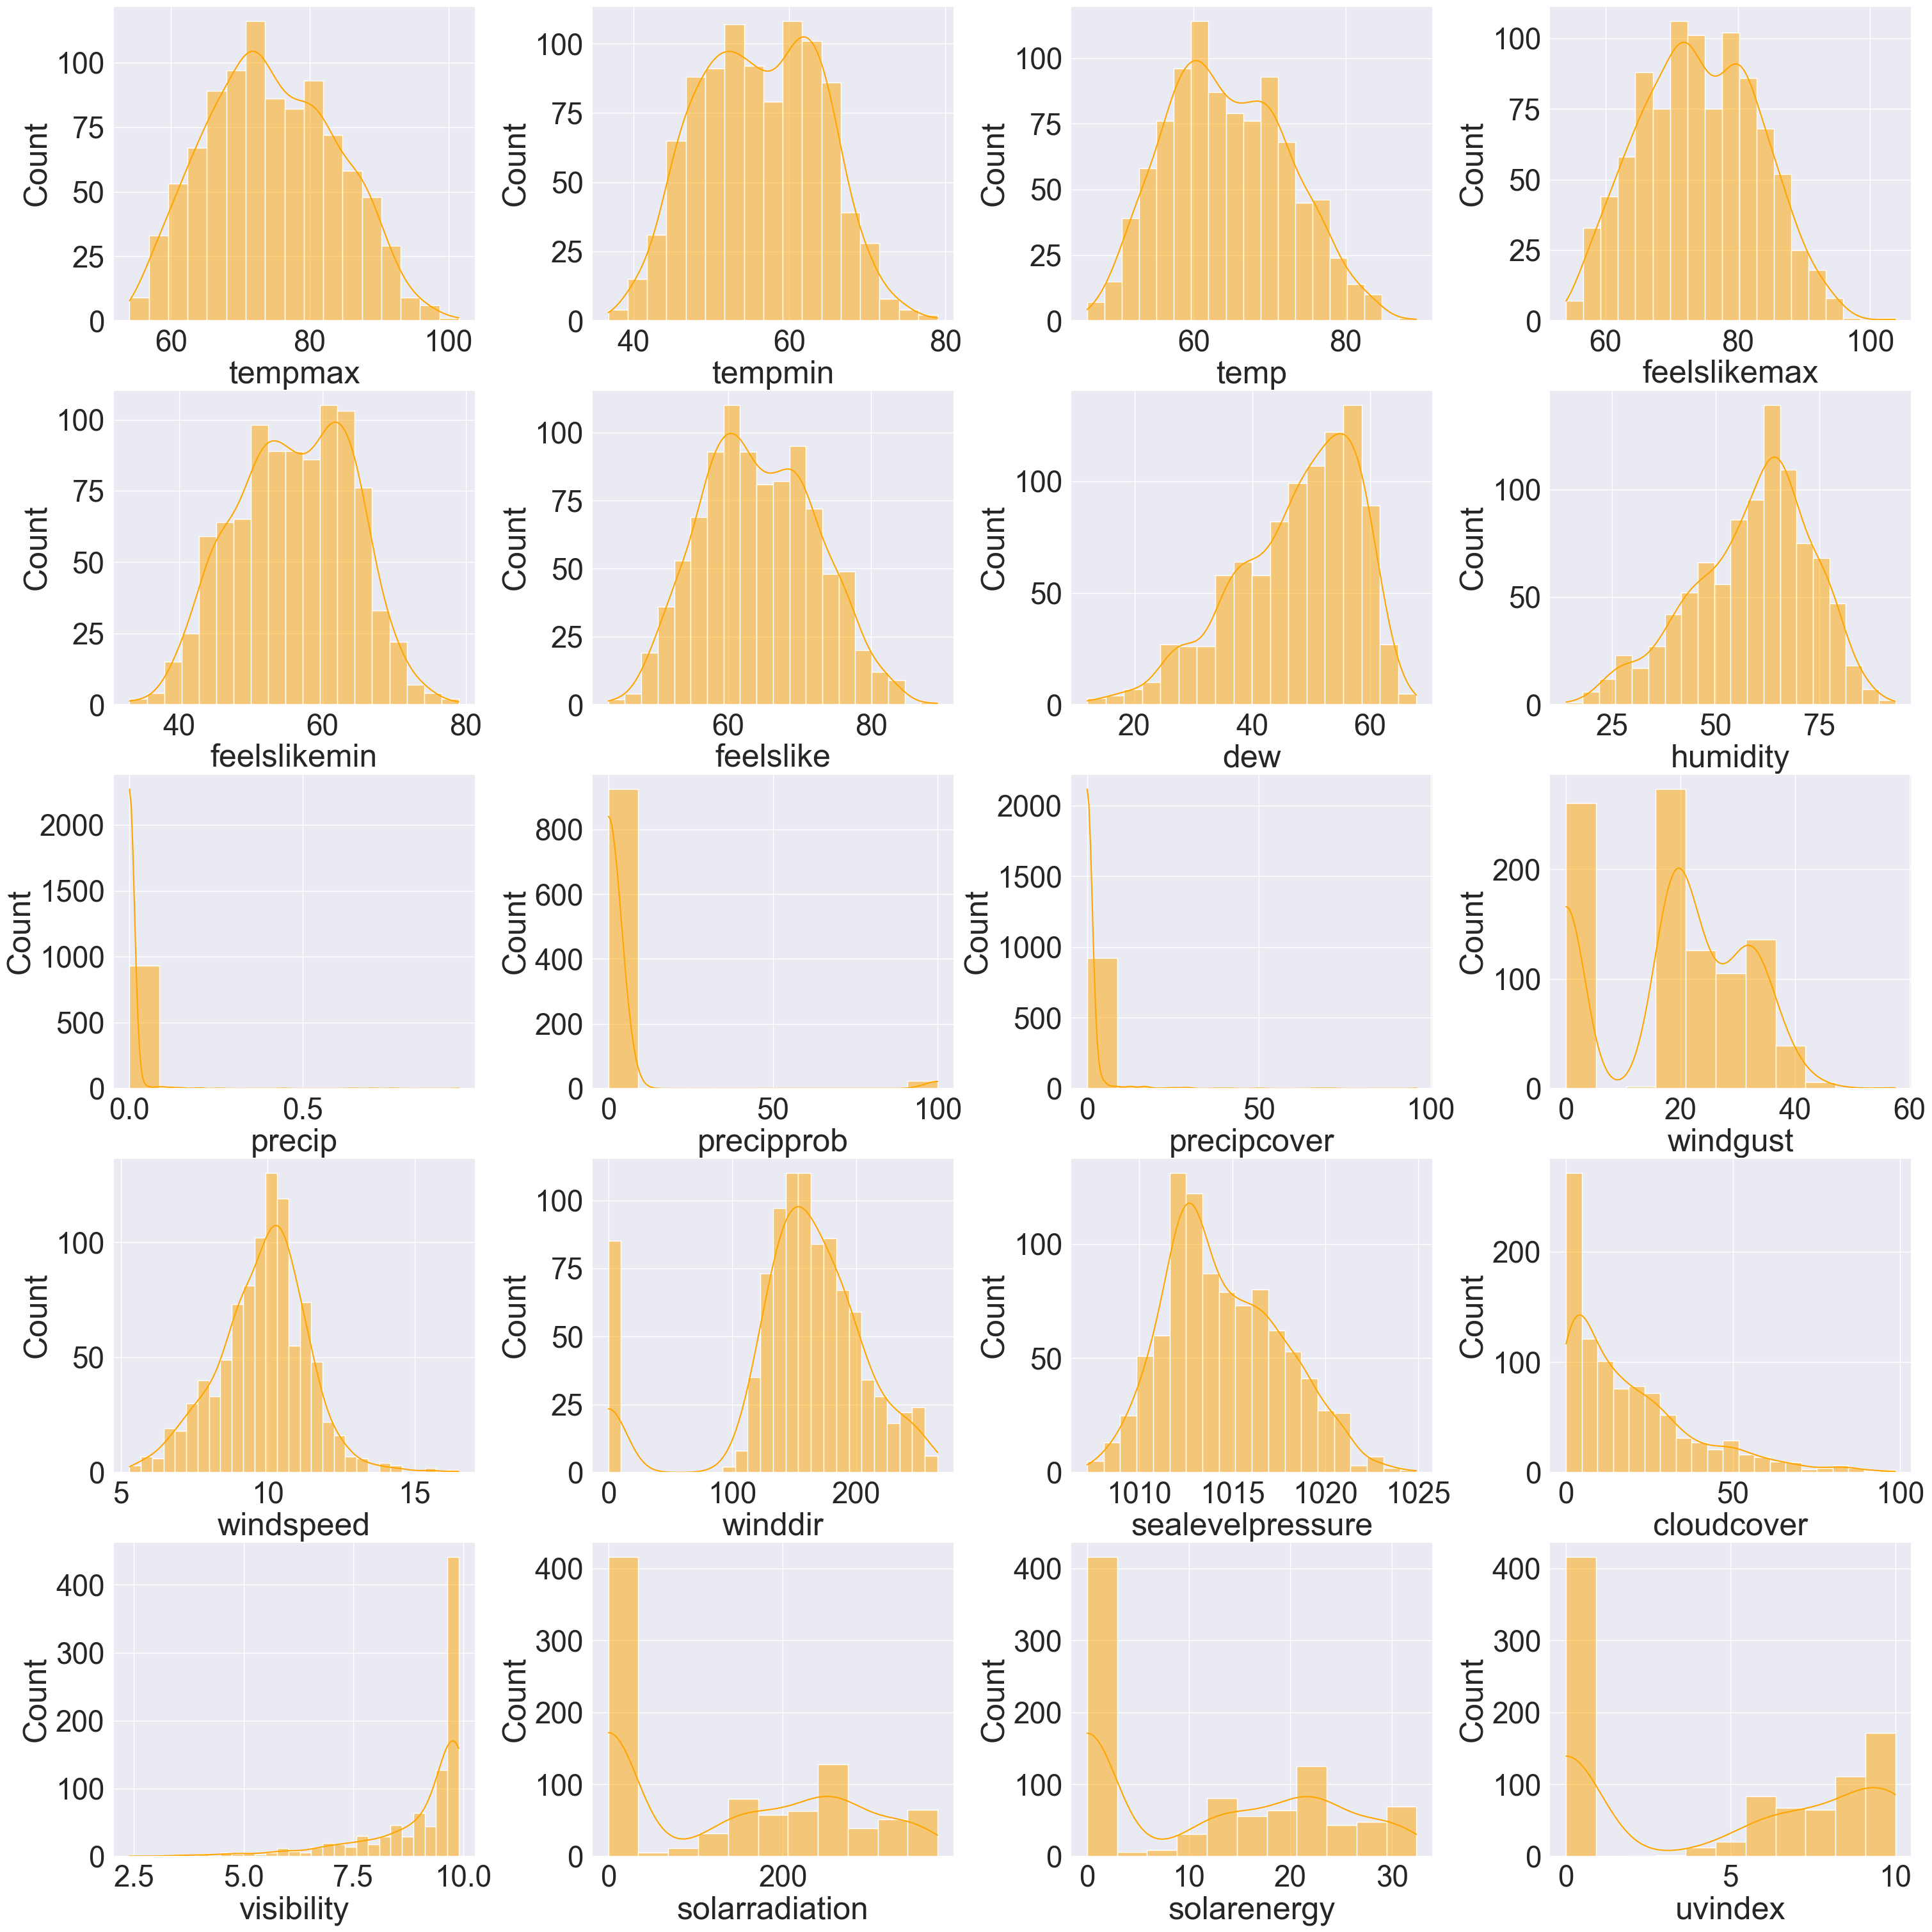

In [25]:
# X_train
sns.set(style="darkgrid")
sns.set(font_scale=3)

num_row_plots = 5
num_col_plots = 4

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.histplot(data = X_train,
                         x = X_train.columns[i],
                         kde=True,
                         color='orange',
                         ax=axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass
fig.tight_layout(pad=0.01)
plt.show()

del num_row_plots, num_col_plots, fig, axs, i

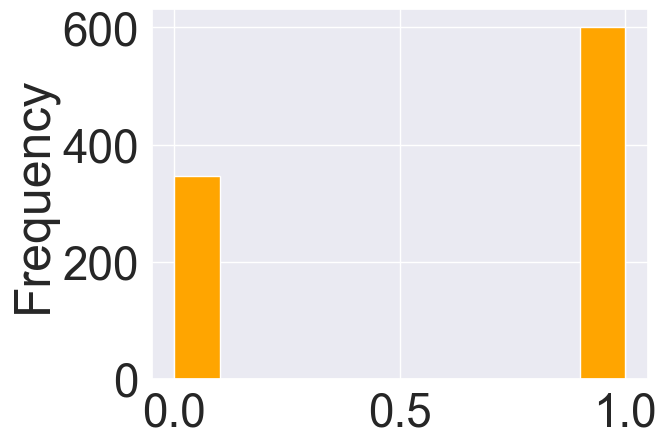

In [26]:
# y_train
plt.Figure(figsize=(30,30))
y_train.plot.hist(color="orange")
plt.show()

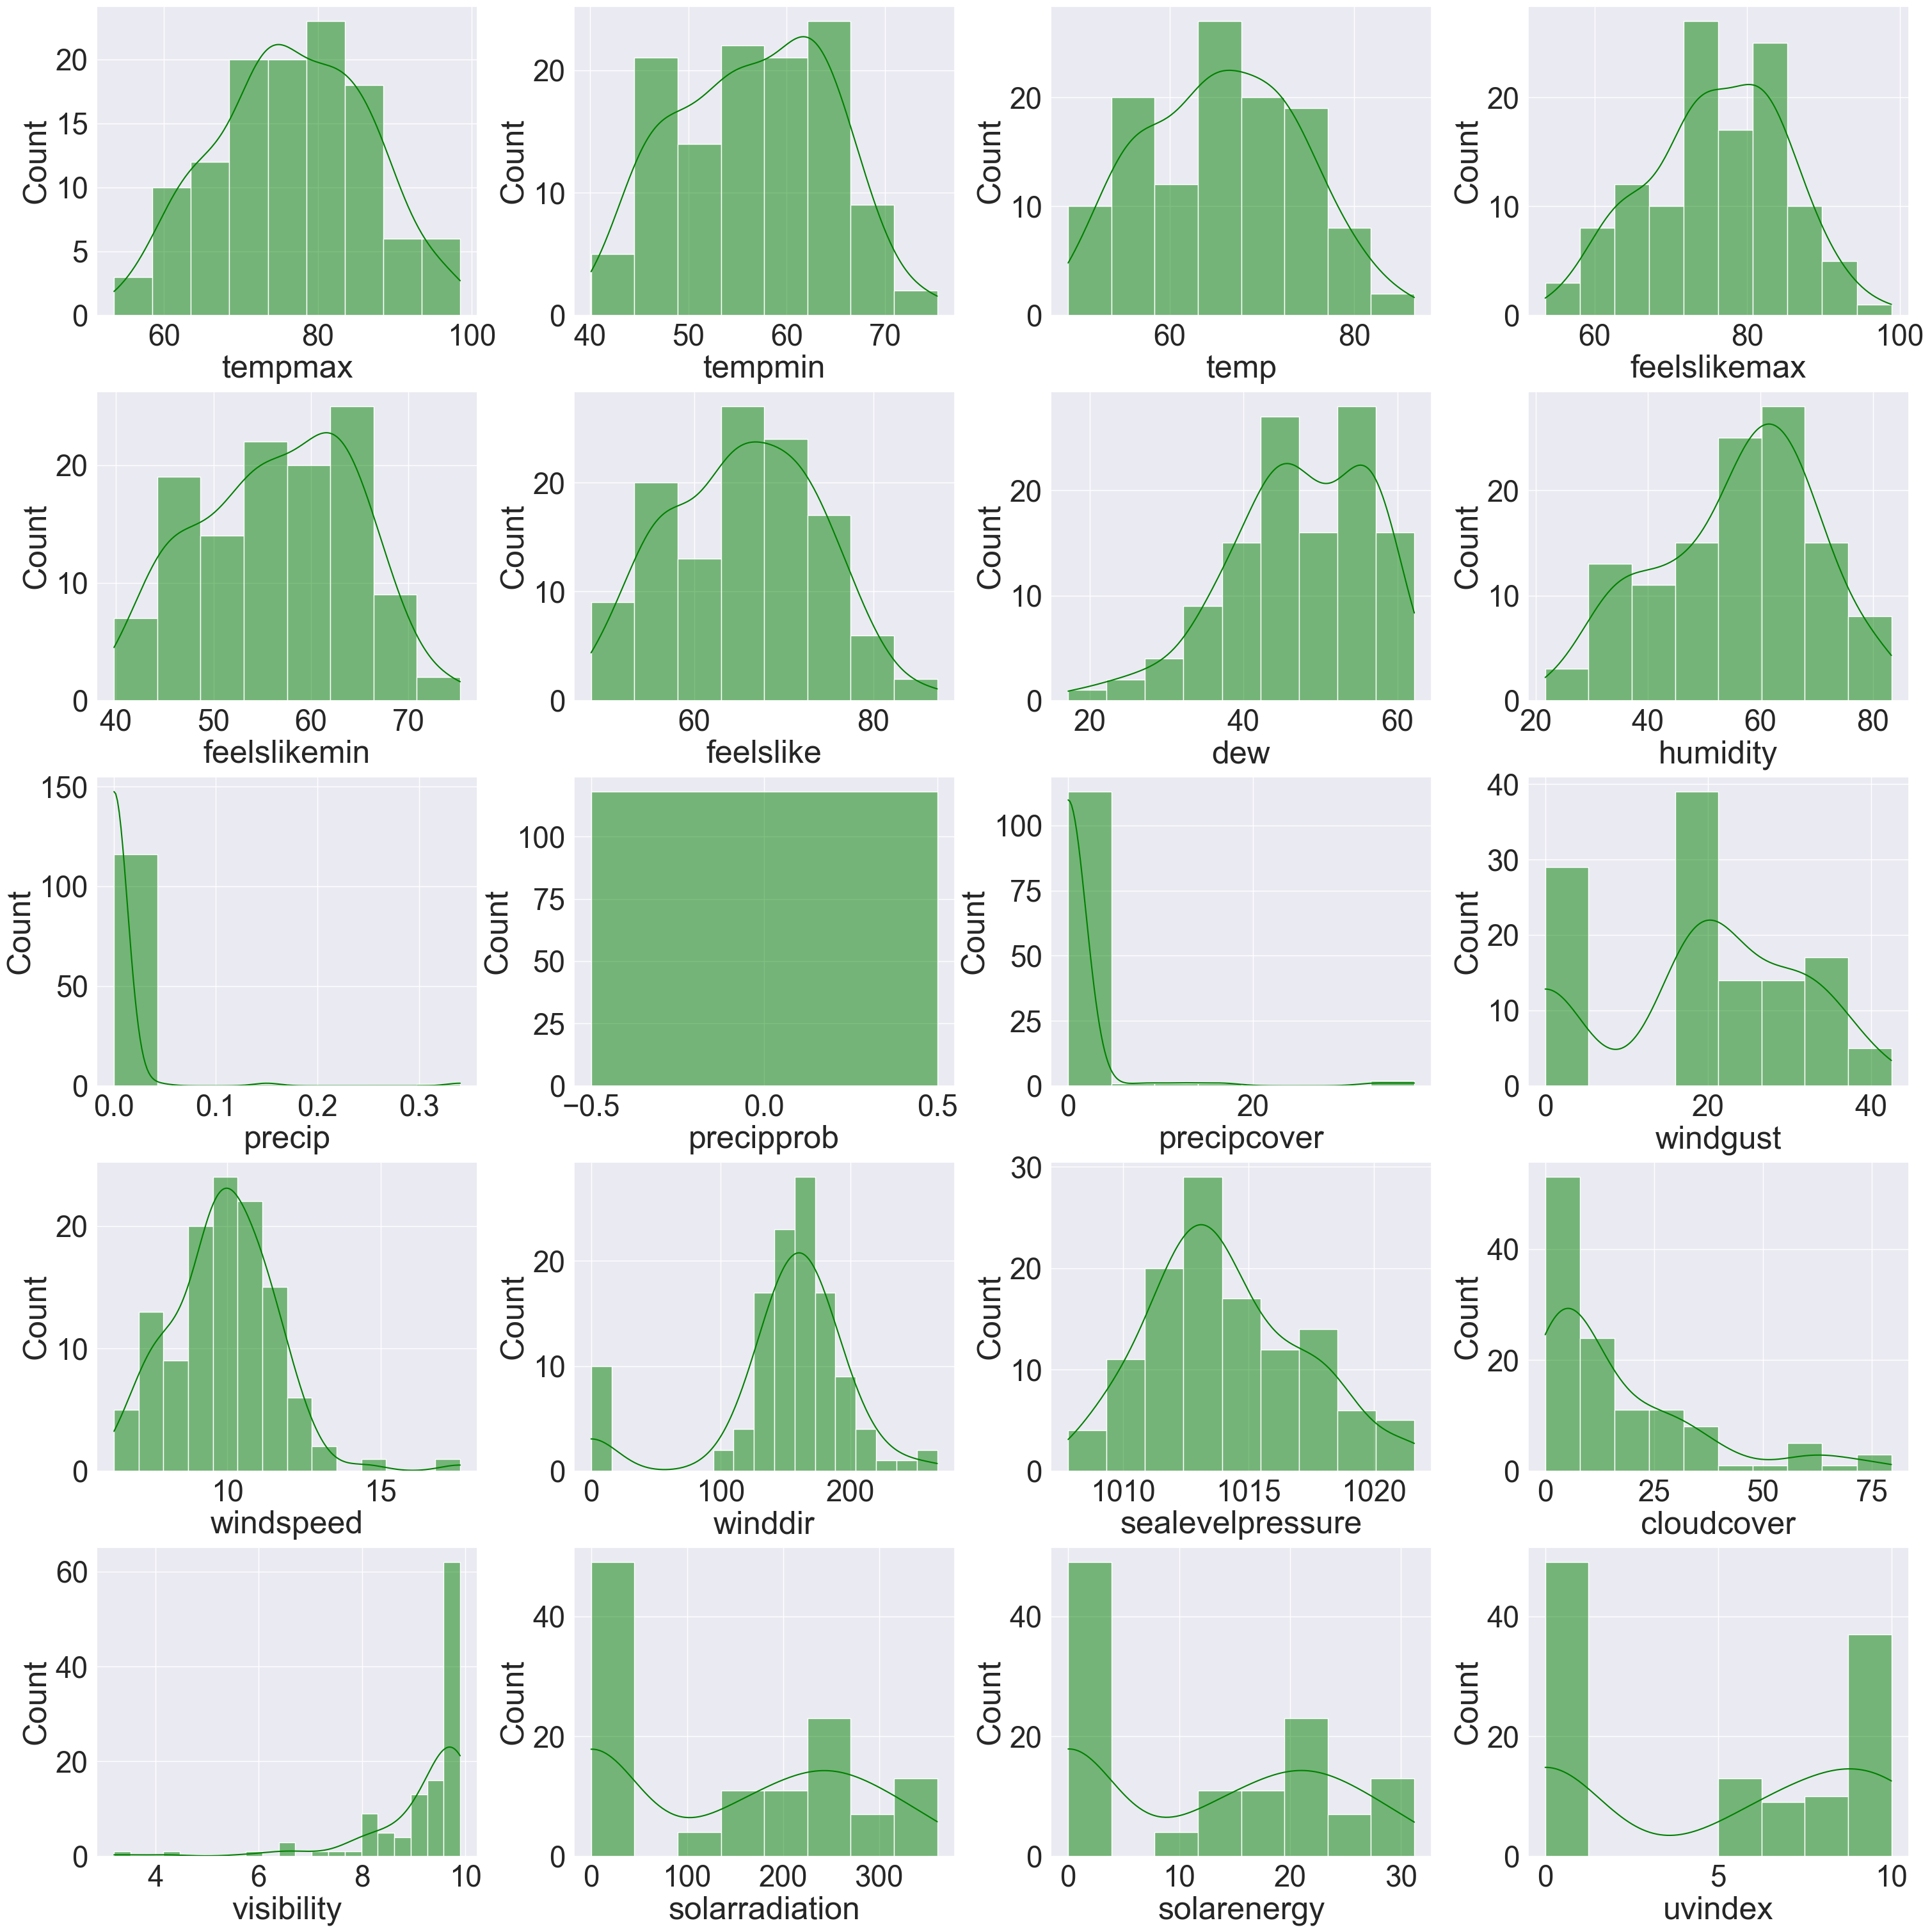

In [27]:
# X_val
sns.set(style="darkgrid")
sns.set(font_scale=3)

num_row_plots = 5
num_col_plots = 4

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.histplot(data = X_val,
                         x = X_val.columns[i],
                         kde=True,
                         color="green",
                         ax=axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass
fig.tight_layout(pad=0.01)
plt.show()
del num_row_plots, num_col_plots, fig, axs, i

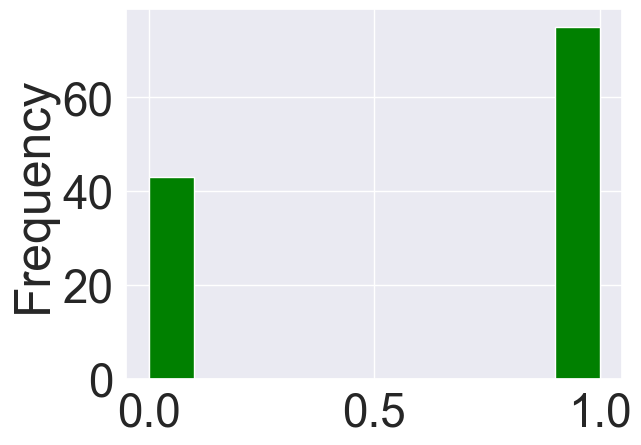

In [28]:
# y_val
plt.Figure(figsize=(30,30))
y_val.plot.hist(color="green")
plt.show()

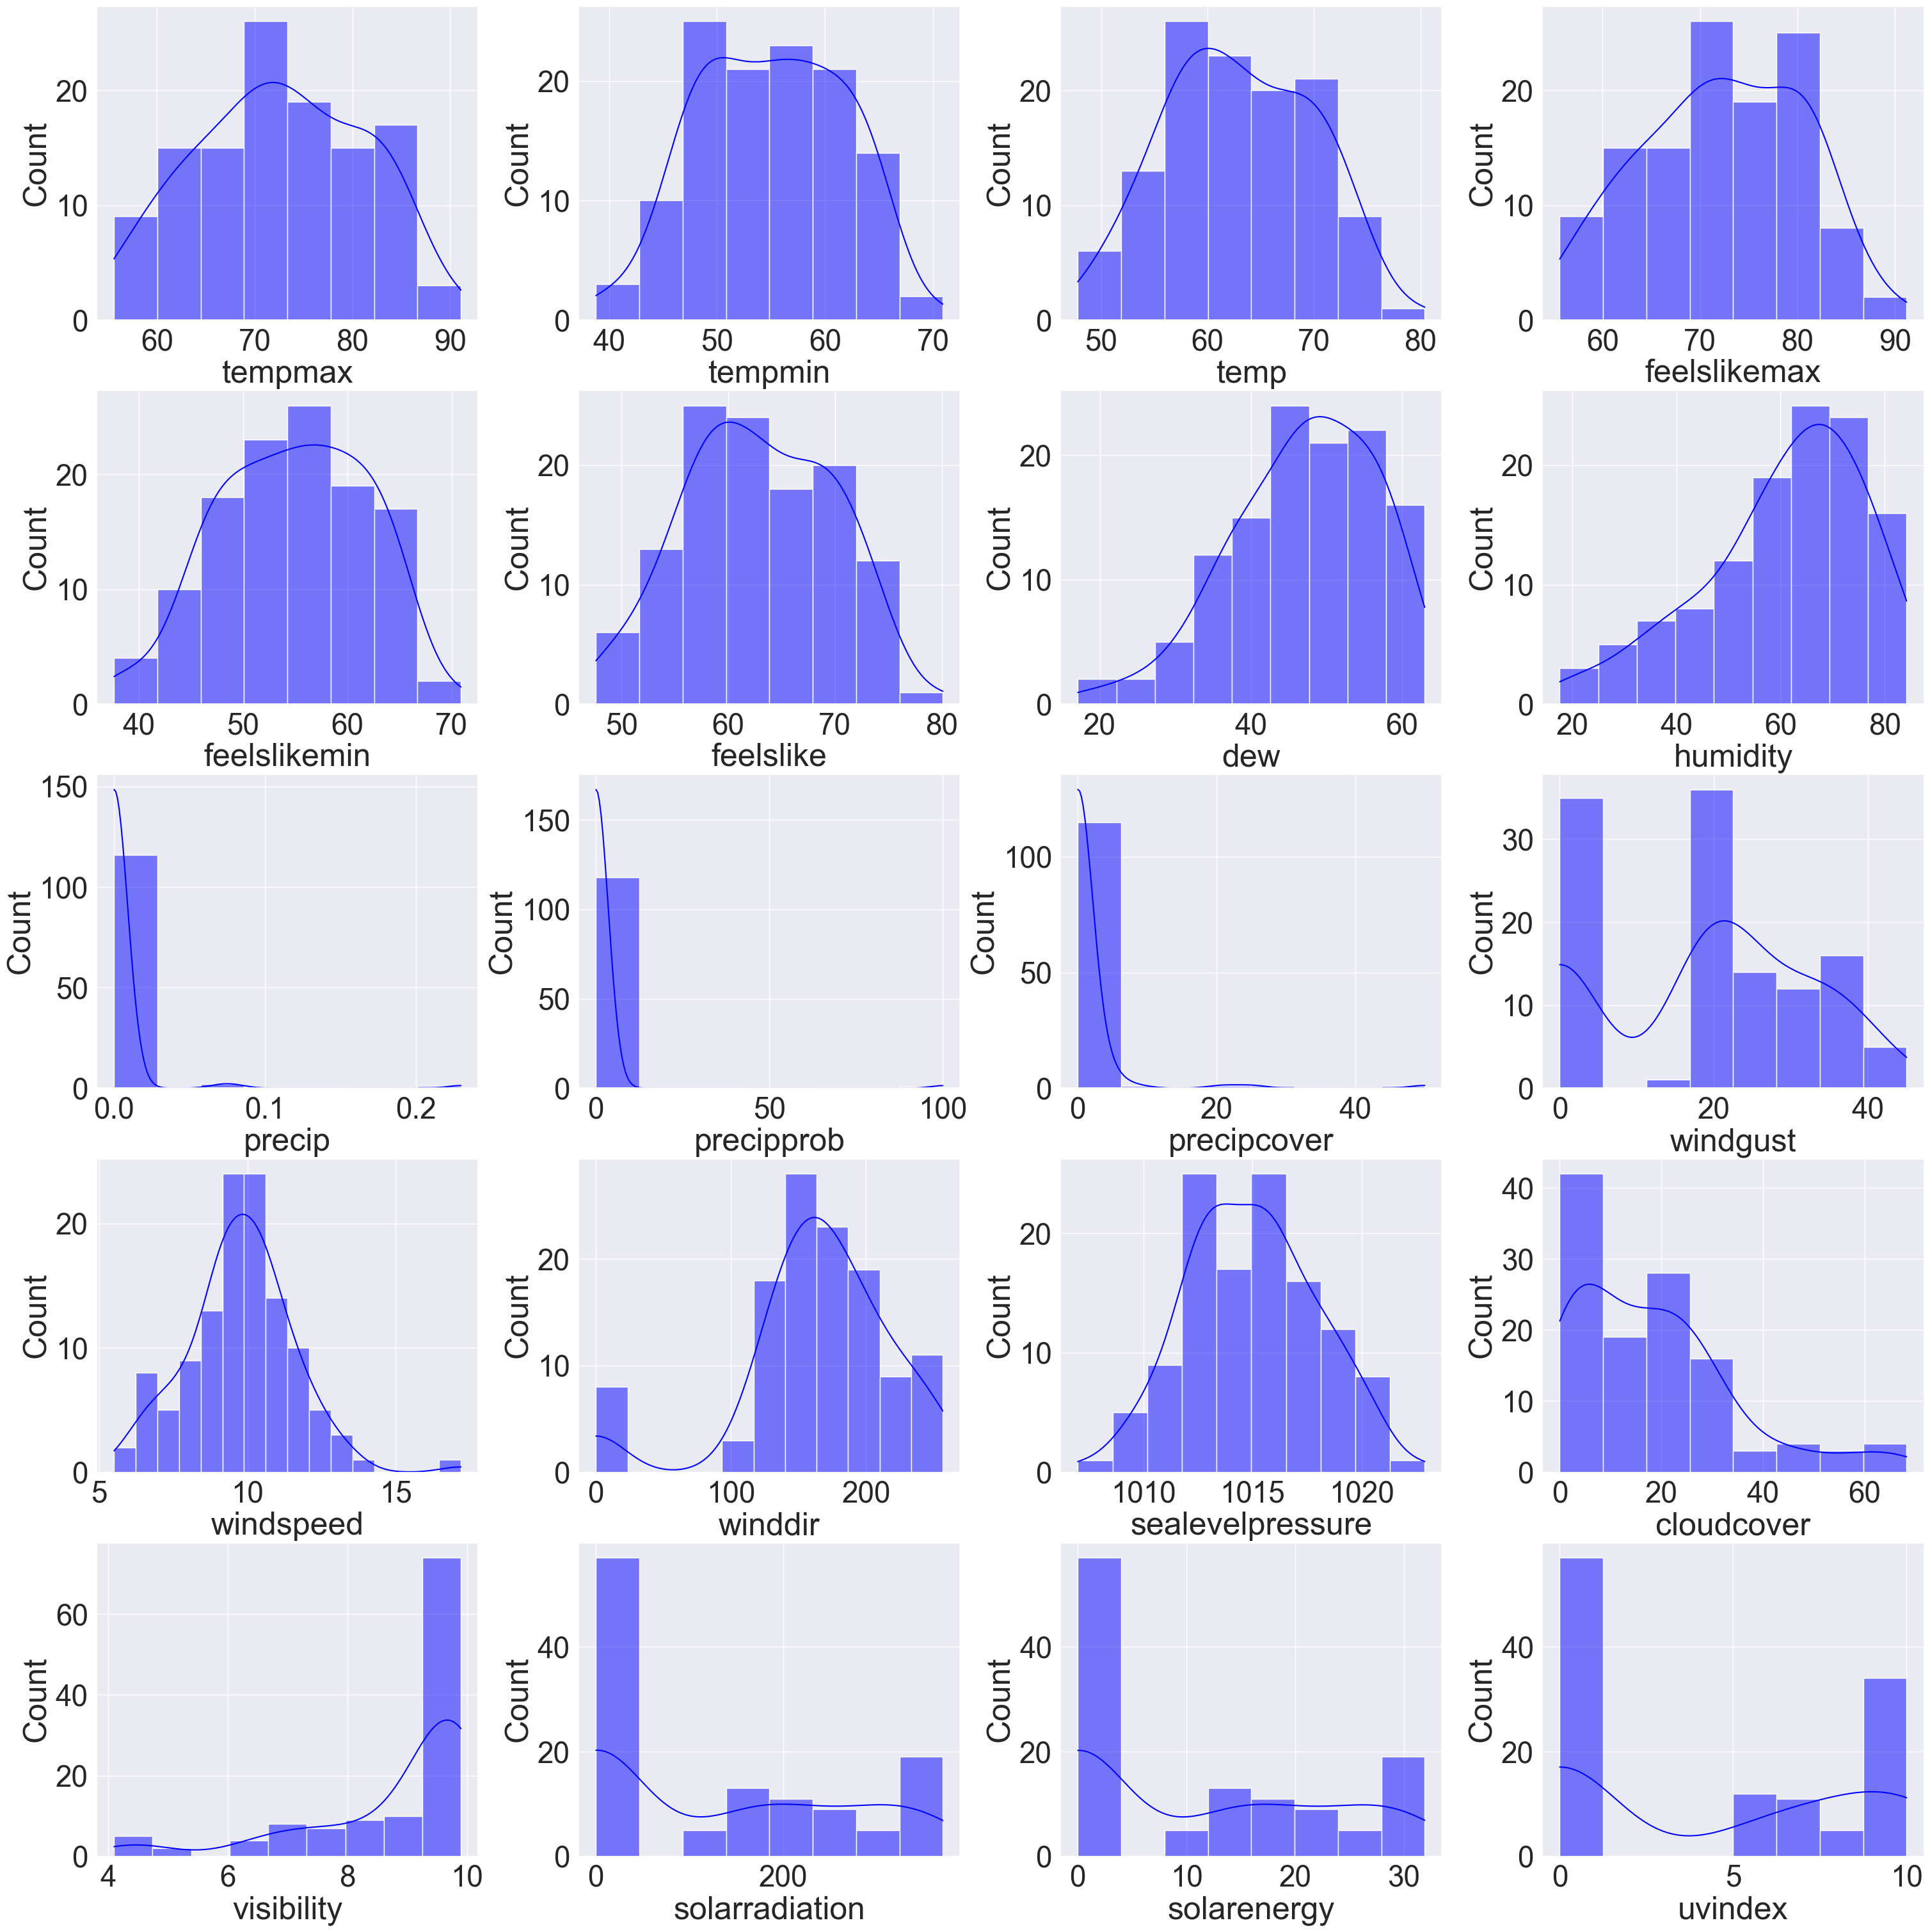

In [29]:
# X_test
sns.set(style="darkgrid")
sns.set(font_scale=3)

num_row_plots = 5
num_col_plots = 4

fig, axs = plt.subplots(num_row_plots, num_col_plots, figsize=(30,30))

i = 0
for row_plot in range(num_row_plots):
    for col_plot in range(num_col_plots):
        try:
            sns.histplot(data = X_test,
                         x = X_test.columns[i],
                         kde=True,
                         color="blue",
                         ax=axs[row_plot, col_plot])
            i += 1
        except Exception as e:
            pass
fig.tight_layout(pad=0.01)
plt.show()

del num_row_plots, num_col_plots, fig, axs, i

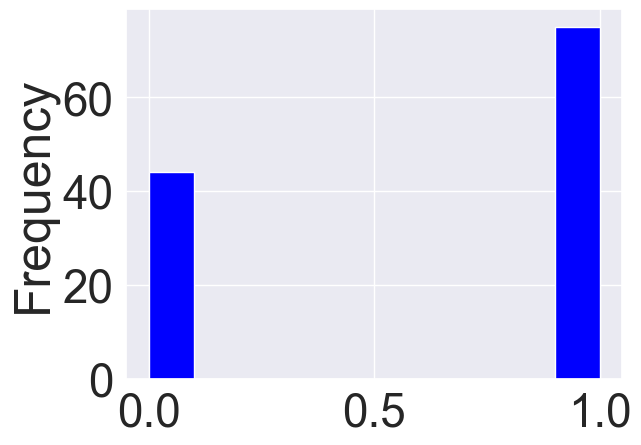

In [30]:
# y_test
plt.Figure(figsize=(30,30))
y_test.plot.hist(color="blue")
plt.show()

# Initialize then fit basic XGBClassifier model and use Early Stopping

In [31]:
import xgboost as xgb
model = xgb.XGBClassifier(random_state = 1234)

model.fit(X_train, y_train, 
          eval_metric="auc", 
          eval_set=[(X_val, y_val)], 
          early_stopping_rounds=10, 
          verbose=False
         )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

## Plot classification error

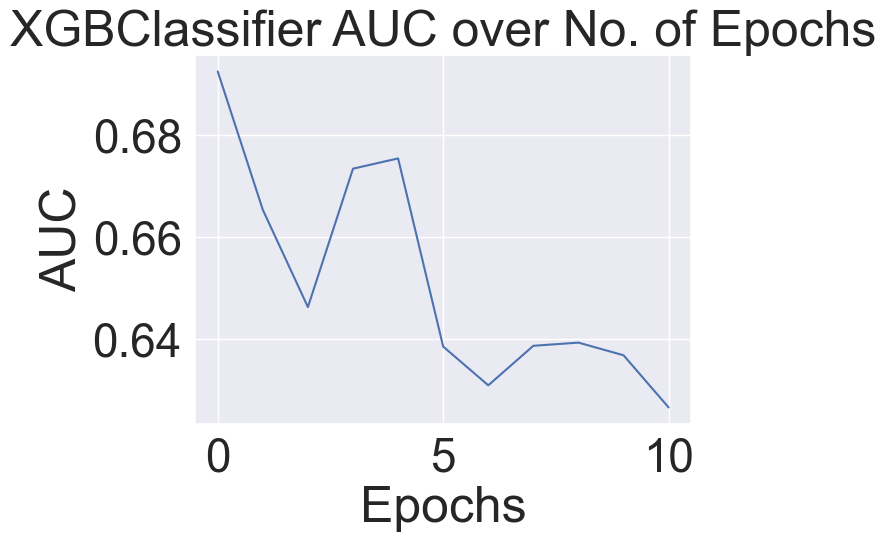

In [32]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'])
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('XGBClassifier AUC over No. of Epochs')
plt.show()

del results, epochs, fig, ax, x_axis

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

In [34]:
y_pred = model.predict(X_test)
init_acc = accuracy_score(y_test, y_pred)
print("Initial Model Accuracy: %.2f%%" % (init_acc * 100.0))

Initial Model Accuracy: 63.03%


In [35]:
score = roc_auc_score(y_test, y_pred)
print("Initial Model roc_auc_score: %.2f%%" % (score * 100.0))

Initial Model roc_auc_score: 59.39%


In [36]:
init_precision, init_recall, init_f1_beta_score, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print(f"Initial Model Precision: {round(init_precision,3)}")
print(f"Initial Model Recall: {round(init_recall,3)}")
print(f"Initial Model F1 Score: {round(init_f1_beta_score,3)}")

Initial Model Precision: 0.696
Initial Model Recall: 0.733
Initial Model F1 Score: 0.714


# SHAP Analysis

In [37]:
import shap

explainer = shap.Explainer(model)
shap_values_train = explainer(X_train)

shap.initjs()

## Use SHAP bar chart to observe the average effects for all features

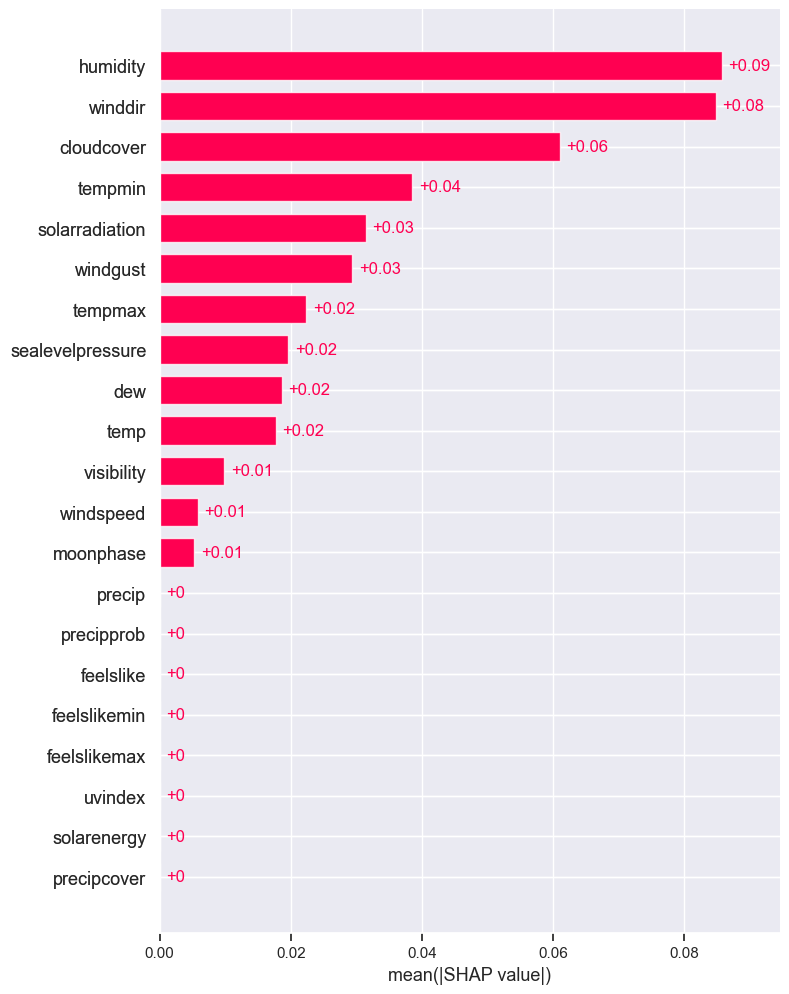

In [38]:
shap.plots.bar(shap_values_train, max_display=21)

## Summarize the effects of all the features

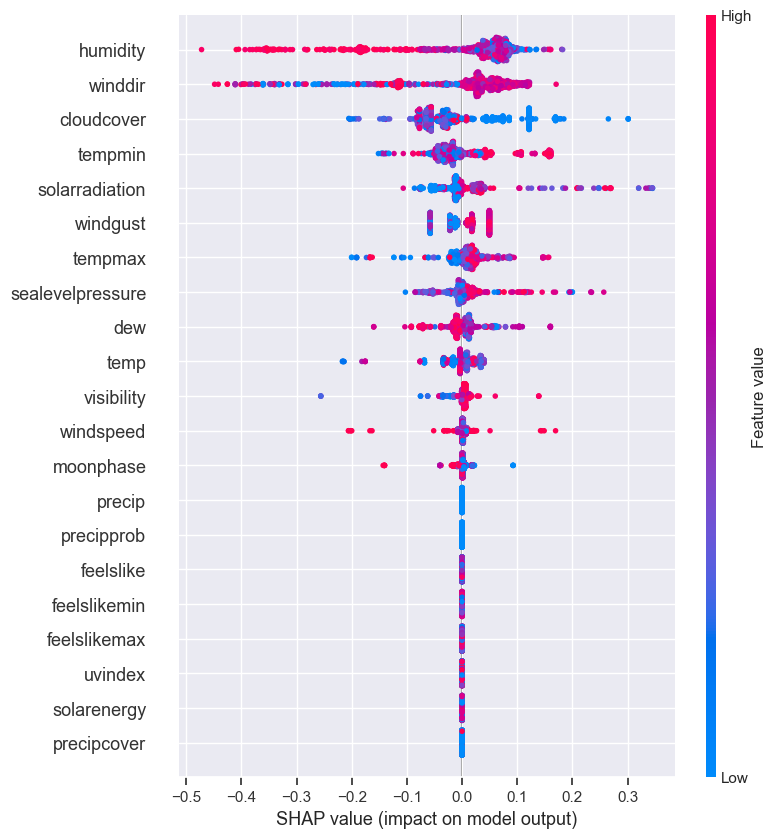

In [39]:
shap.plots.beeswarm(shap_values_train, max_display=21)

# Address imbalanced data after training initial model

Best Threshold=0.608489


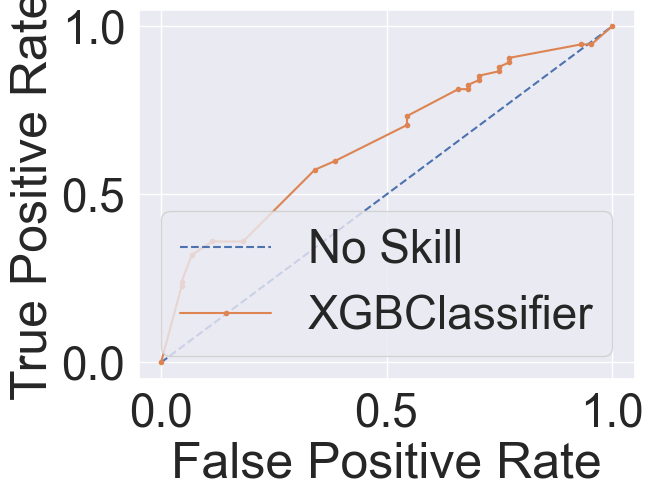

In [40]:
y_pred_proba = model.predict_proba(X_test)[:,1] # get positive class values only

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# calculate the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print('Best Threshold=%f' % (best_threshold))

# generate initial AUC-ROC Curve with imbalanced data
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

#### Make predictions for test data and evaluate

In [41]:
from sklearn.metrics import precision_recall_curve

In [51]:
y_pred_proba_new = np.where(y_pred_proba >=best_threshold, 1, 0)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# convert to f score
fscores = (2 * precisions * recalls) / (precisions + recalls)

# locate the index of the largest f score
ix = np.argmax(fscores)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscores[ix]))

Best Threshold=0.385405, F-Score=0.773


In [43]:
# rebalance predictions with new threshold

accuracy_new = accuracy_score(y_test, y_pred_proba_new)
print("Pre-Balancing Accuracy: %.2f%%" % (init_acc * 100.0))
print("Post-Balancing Accuracy: %.2f%%" % (accuracy_new * 100.0))

Pre-Balancing Accuracy: 63.03%
Post-Balancing Accuracy: 54.62%


In [44]:
score_new = roc_auc_score(y_test, y_pred_proba_new)
print("Pre-Balancing roc_auc_score: %.2f%%" % (score * 100.0))
print("Post-Balancing roc_auc_score: %.2f%%" % (score_new * 100.0))

Pre-Balancing roc_auc_score: 59.39%
Post-Balancing roc_auc_score: 62.59%


In [45]:
new_precision, new_recall, new_f1_beta_score, _ = precision_recall_fscore_support(y_test, y_pred_proba_new, average="binary")

print(f"Pre-balancing Precision: {round(init_precision,3)}")
print(f"Post-balancing Precision: {round(new_precision,3)}\n")

print(f"Pre-balancing Recall: {round(init_recall,3)}")
print(f"Post-balancing Recall: {round(new_recall,3)}\n")

print(f"Pre-balancing F1 Score: {round(init_f1_beta_score,3)}")
print(f"Post-balancing F1 Score: {round(new_f1_beta_score,3)}\n")

Pre-balancing Precision: 0.696
Post-balancing Precision: 0.889

Pre-balancing Recall: 0.733
Post-balancing Recall: 0.32

Pre-balancing F1 Score: 0.714
Post-balancing F1 Score: 0.471



# Removing Misclassifying Features and Post-Removal Results

## Misclassification False Positive scenario

In [46]:
false_pos = (y_pred_proba_new == 1) & (y_test == 0) 
shap_values_false_pos = explainer.shap_values(X_test[false_pos])

#### Observe feature effects on 10 False Positive samples

In [47]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[0], X_test[false_pos].columns)

In [48]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[1], X_test[false_pos].columns)

In [49]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[2], X_test[false_pos].columns)

In [50]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[3], X_test[false_pos].columns)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[4], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[5], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[6], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[7], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[8], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[9], X_test[false_pos].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_pos[10], X_test[false_pos].columns)

#### Summarize feature effects using SHAP bar and beeswarm plots

In [ ]:
shap.plots.bar(explainer(X_test[false_pos]), max_display=21)

In [ ]:
shap.summary_plot(explainer(X_test[false_pos]), max_display=21)

del false_pos, shap_values_false_pos

### Misclassification False Negative scenario

In [ ]:
false_neg = (y_pred_proba_new == 0) & (y_test == 1)
shap_values_false_neg = explainer.shap_values(X_test[false_neg])

#### Observe feature effects on 10 False Negative samples

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[0], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[1], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[2], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[3], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[4], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[5], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[6], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[7], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[8], X_test[false_neg].columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values_false_neg[9], X_test[false_neg].columns)

#### Summarize feature effects using SHAP bar and beeswarm plots

In [ ]:
shap.plots.bar(explainer(X_test[false_neg]), max_display=21)

In [ ]:
shap.plots.beeswarm(explainer(X_test[false_neg]), max_display=21)

del false_neg, shap_values_false_neg

In [ ]:
## Remodelling after removing "humidity", "winddir", "cloudcover"
X_train_new = X_train.drop(columns =["humidity" , "winddir","cloudcover"])
X_val_new = X_val.drop(columns =["humidity" , "winddir","cloudcover"])
X_test_new = X_test.drop(columns =["humidity" , "winddir","cloudcover"])

model_new = xgb.XGBClassifier(random_state = 4321)

model_new.fit(X_train_new, y_train, 
                  eval_metric="auc", 
                  eval_set=[(X_val_new, y_val)], 
                  early_stopping_rounds=10, 
                  verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

pred = model_new.predict_proba(X_test_new)[:,1]
pred = np.where(pred >=best_threshold, 1, 0)
post_drop_acc = accuracy_score(y_test, pred)
print("Accuracy after dropping misclassified columns: %.2f%%" % (post_drop_acc * 100.0))

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'])
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('XGBClassifier AUC over No. of Epochs')
plt.show()

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Randomized Search Cross-Validation

In [ ]:
rs_params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

rs_model=RandomizedSearchCV(model,
                            param_distributions=rs_params,
                            n_iter=5,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=5,
                            verbose=3)

rs_model.fit(X_train_new, y_train)
tuned_rs_model = rs_model.best_estimator_
print(tuned_rs_model)

In [ ]:
tuned_rs_pred = tuned_rs_model.predict(X_test_new)
tuned_rs_accuracy = accuracy_score(y_test, tuned_rs_pred)
tuned_rs_score = roc_auc_score(y_test, tuned_rs_pred)
tuned_rs_precision, tuned_rs_recall, tuned_rs_f1_beta_score, _ = precision_recall_fscore_support(y_test, 
                                                                                                 tuned_rs_pred, 
                                                                                                 average="binary")

## Grid Search Cross-Validation

In [ ]:
gs_params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

gs_model=GridSearchCV(model,
                            param_grid=gs_params,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=5,
                            verbose=3)

gs_model.fit(X_train_new, y_train)
tuned_gs_model = gs_model.best_estimator_
print(tuned_gs_model)

In [ ]:
tuned_gs_pred = tuned_gs_model.predict(X_test_new)
tuned_gs_accuracy = accuracy_score(y_test, tuned_gs_pred)
tuned_gs_score = roc_auc_score(y_test, tuned_gs_pred)
tuned_gs_precision, tuned_gs_recall, tuned_gs_f1_beta_score, _ = precision_recall_fscore_support(y_test, 
                                                                                                 tuned_gs_pred, 
                                                                                                 average="binary")

## Ray Tune Library

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def train_drought_classifier(config):
    """
    This is a simple training function to be passed into Tune
    """
    
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(X_train_new, label=y_train)
    test_set = xgb.DMatrix(X_test_new, label=y_test)
    # Train the classifier, using the Tune callback
    xgb.train(
             config,
             train_set,
             evals=[(test_set, "eval")],
             verbose_eval=False
            )

In [ ]:
rt_params = {
            "objective": "binary:logistic",
            "eval_metric": ["auc"],
            "max_depth": tune.randint(1, 9),
            "min_child_weight": tune.choice([1, 2, 3]),
            "subsample": tune.uniform(0.5, 1.0),
            "eta": tune.loguniform(1e-4, 1e-1)
            }

scheduler = ASHAScheduler(
                        max_t=10, 
                        grace_period=1, 
                        reduction_factor=2  # 10 training iterations
                        )

config = tune.TuneConfig(
            metric="eval-auc",
            mode="max",
            scheduler=scheduler,
            num_samples=10
            )


tuner = tune.Tuner(
            train_drought_classifier,
            tune_config=config,
            param_space=rt_params
            )

results = tuner.fit()
best_result = results.get_best_result()
# tuned_rt_accuracy = 1.0 - best_result.metrics["eval-error"]

print(f"Best model parameters: {best_result.config}")
# print(f"Best model total accuracy: {accuracy:.4f}")
print(best_result.metrics)

In [ ]:
print(best_result.metrics)

## Tuning Results

In [ ]:
print("Pre-Balancing Accuracy: %.2f%%" % (init_acc * 100.0))
print("Post-Balancing Accuracy: %.2f%%" % (accuracy_new * 100.0))
print("Accuracy after RandomizedSearchCV tuning: %.2f%%" % (tuned_rs_accuracy * 100.0))
print("Accuracy after GridSearchCV tuning: %.2f%%" % (tuned_gs_accuracy * 100.0))
# print("Accuracy after Ray Tune library tuning: %.2f%%" % (tuned_rt_accuracy * 100.0))

In [ ]:
print(f"Pre-Balancing roc_auc_score: {round(score,3)}")
print(f"Post-Balancing roc_auc_score: {round(score_new,3)}")
print(f"roc_auc_score after RandomizedSearchCV tuning: {round(tuned_rs_precision,3)}")
print(f"roc_auc_score after GridSearchCV tuning: {round(tuned_gs_precision,3)}")
# print(f"roc_auc_score after Ray Tune library tuning: {round(tuned_gs_precision,3)}\n")

In [ ]:
print(f"Pre-balancing Precision: {round(init_precision,3)}")
print(f"Post-balancing Precision: {round(new_precision,3)}")
print(f"Precision after RandomizedSearchCV tuning: {round(tuned_rs_precision,3)}")
print(f"Precision after GridSearchCV tuning: {round(tuned_rs_precision,3)}")
# print(f"Precision after Ray Tune library tuning: {round(tuned_rs_precision,3)}\n")

In [ ]:
print(f"Pre-balancing Recall: {round(init_recall,3)}")
print(f"Post-balancing Recall: {round(new_recall,3)}")
print(f"Recall after RandomizedSearchCV tuning: {round(tuned_rs_recall,3)}")
print(f"Recall after GridSearchCV tuning: {round(tuned_rs_recall,3)}")
# print(f"Recall after Ray Tune library tuning: {round(tuned_rs_recall,3)}\n")

In [ ]:
print(f"Pre-balancing F1 Score: {round(init_f1_beta_score,3)}")
print(f"Post-balancing F1 Score: {round(new_f1_beta_score,3)}")
print(f"F1 Score after RandomizedSearchCV tuning: {round(tuned_rs_f1_beta_score,3)}")
print(f"F1 Score after GridSearchCV tuning: {round(tuned_gs_f1_beta_score,3)}")
# print(f"F1 Score after Ray Tune library tuning: {round(tuned_rt_f1_beta_score,3)}")